# DNNs and CNNs using Kuzushiji-MNIST

* **Project:** M3: Mini Project
* **Author:** Jacob Buysse

In this project we will explore the Kuzushiji-MNIST dataset: a drop-in replacement for MNIST using 10 classes of Kuzushiji (cursive Japanese).
* [Source Paper](https://nips2018creativity.github.io/doc/deep_learning_for_classical_japanese_literature.pdf)

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import confusion_matrix

Let us configure matplotlib for readable labels, high resolution, and automatic layout.

In [2]:
matplotlib.rc("axes", labelsize=14)
matplotlib.rc("figure", dpi=150, autolayout=False)

Let us load the datasets and take a look at the data.

In [3]:
train_X = np.load('./kmnist-train-imgs.npz')['arr_0']
train_y = np.load('./kmnist-train-labels.npz')['arr_0']
test_X = np.load('./kmnist-test-imgs.npz')['arr_0']
test_y = np.load('./kmnist-test-labels.npz')['arr_0']

In [4]:
print(f"Train X {train_X.shape}, y {train_y.shape}, Test X {test_X.shape}, y {test_y.shape}")

Train X (60000, 28, 28), y (60000,), Test X (10000, 28, 28), y (10000,)


So we have 60,000 28x28 training images with classes and 10,000 28x28 testing images with classes.  Let us look at a few items from some of the classes.

In [5]:
df_train_y = pd.DataFrame(train_y)
df_train_y.value_counts()

0
0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: count, dtype: int64

We have a balanced class distribution with 6,000 images per each of the 10 classes 0 through 9.

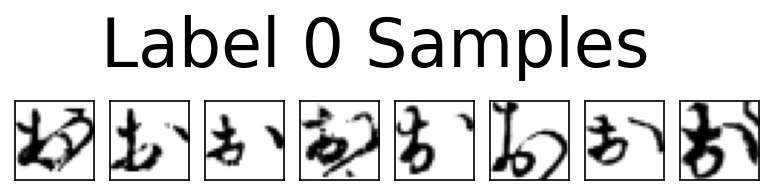

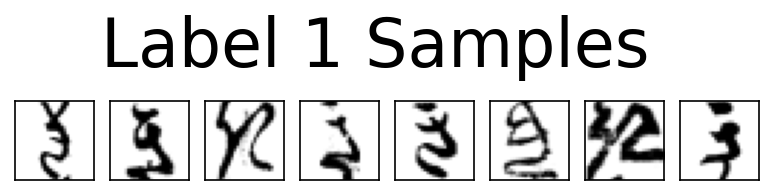

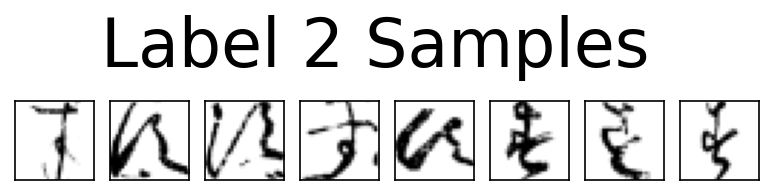

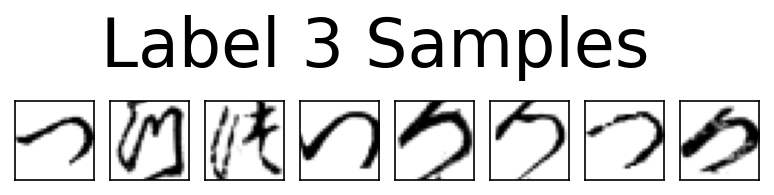

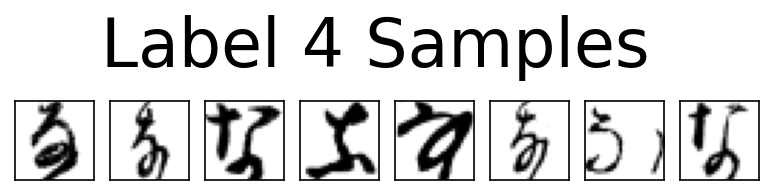

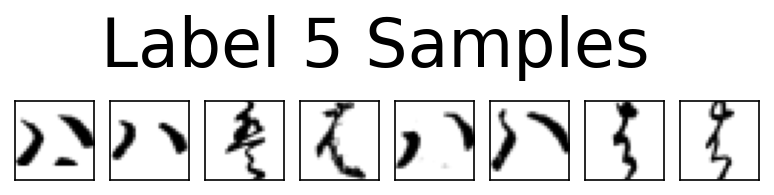

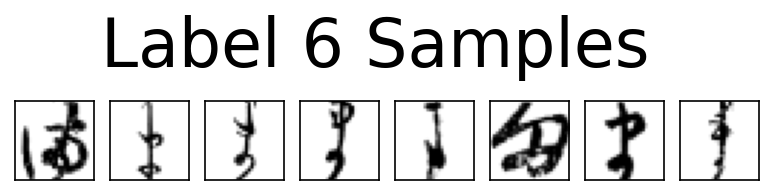

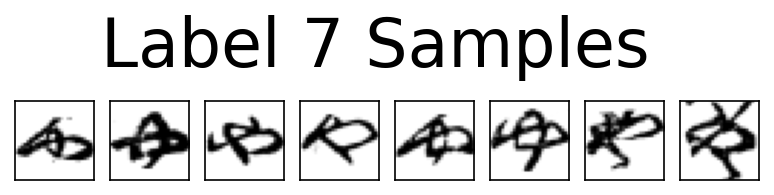

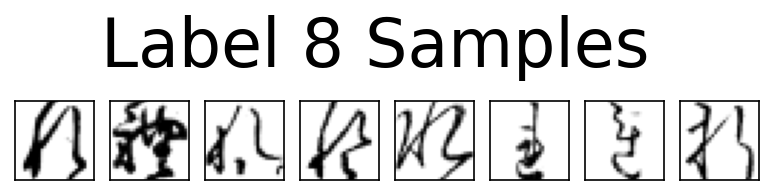

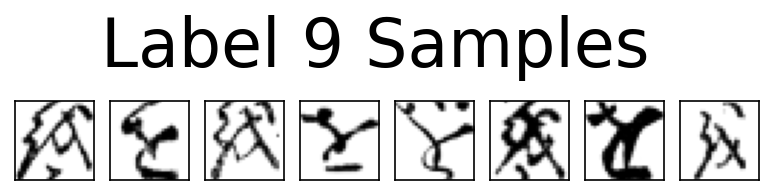

In [6]:
def show_class(label, count=8):
    images = train_X[df_train_y[0] == label]
    fig, axarr = plt.subplots(1, count)
    for index in range(0, count):
        pixels = images[index]
        axarr[index].imshow(pixels, cmap='gray_r', vmin=0, vmax=255)
        axarr[index].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig.suptitle(f"Label {label} Samples", fontsize=32)
    plt.subplots_adjust(top=1.5)
    plt.show()
for label in range(0, 10):
    show_class(label)

Let us finish preparing our data by converting to 4D tensors (with final channel size of 1) and scaling our grayscale pixels from 0-255 (int) to 0-1 (float).

In [7]:
keras_train_X = train_X.reshape(60000, 28, 28, 1) / 255.0
keras_test_X = test_X.reshape(10000, 28, 28, 1) / 255.0
keras_train_y = to_categorical(train_y, num_classes=10)
keras_test_y = to_categorical(test_y, num_classes=10)
print(f"New shapes, train X {keras_train_X.shape} y {keras_train_y.shape}, test X {keras_test_X.shape} y {keras_test_y.shape}")

New shapes, train X (60000, 28, 28, 1) y (60000, 10), test X (10000, 28, 28, 1) y (10000, 10)


Let us define a helper function for evaluating our models.

In [8]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Let us define a helper function to show the confusion matrix for our models.

In [28]:
def plot_confusion_matrix(model):
    predicted_y = model.predict(keras_test_X)
    predicted_labels = np.argmax(predicted_y, axis=1)
    true_labels = np.argmax(keras_test_y, axis=1)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(
                j,
                i,
                format(conf_matrix[i, j], 'd'),
                ha="center",
                va="center",
                color="white" if conf_matrix[i, j] > thresh else "black"
            )
    plt.colorbar()
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(10), rotation=45)
    plt.yticks(np.arange(10))
    plt.tight_layout()
    plt.show()
    return predicted_labels

## DNNs

Now let us create our initial model using a flatten layer, 2 dense 8 node layers, and a 10 node output layer.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4489 - loss: 1.6597 - val_accuracy: 0.7172 - val_loss: 0.9391
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7391 - loss: 0.8576 - val_accuracy: 0.7753 - val_loss: 0.7638
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.7849 - loss: 0.7150 - val_accuracy: 0.7919 - val_loss: 0.6962
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.8014 - loss: 0.6564 - val_accuracy: 0.8007 - val_loss: 0.6612
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.8162 - loss: 0.6081 - val_accuracy: 0.8091 - val_loss: 0.6332
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.8254 - loss: 0.5889 - val_accuracy: 0.8144 - val_loss: 0.6158
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.8318 - loss: 0.5640 - val_accuracy: 0.8189 - val_loss: 0.6049
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.8325 - loss: 0.5462 - va

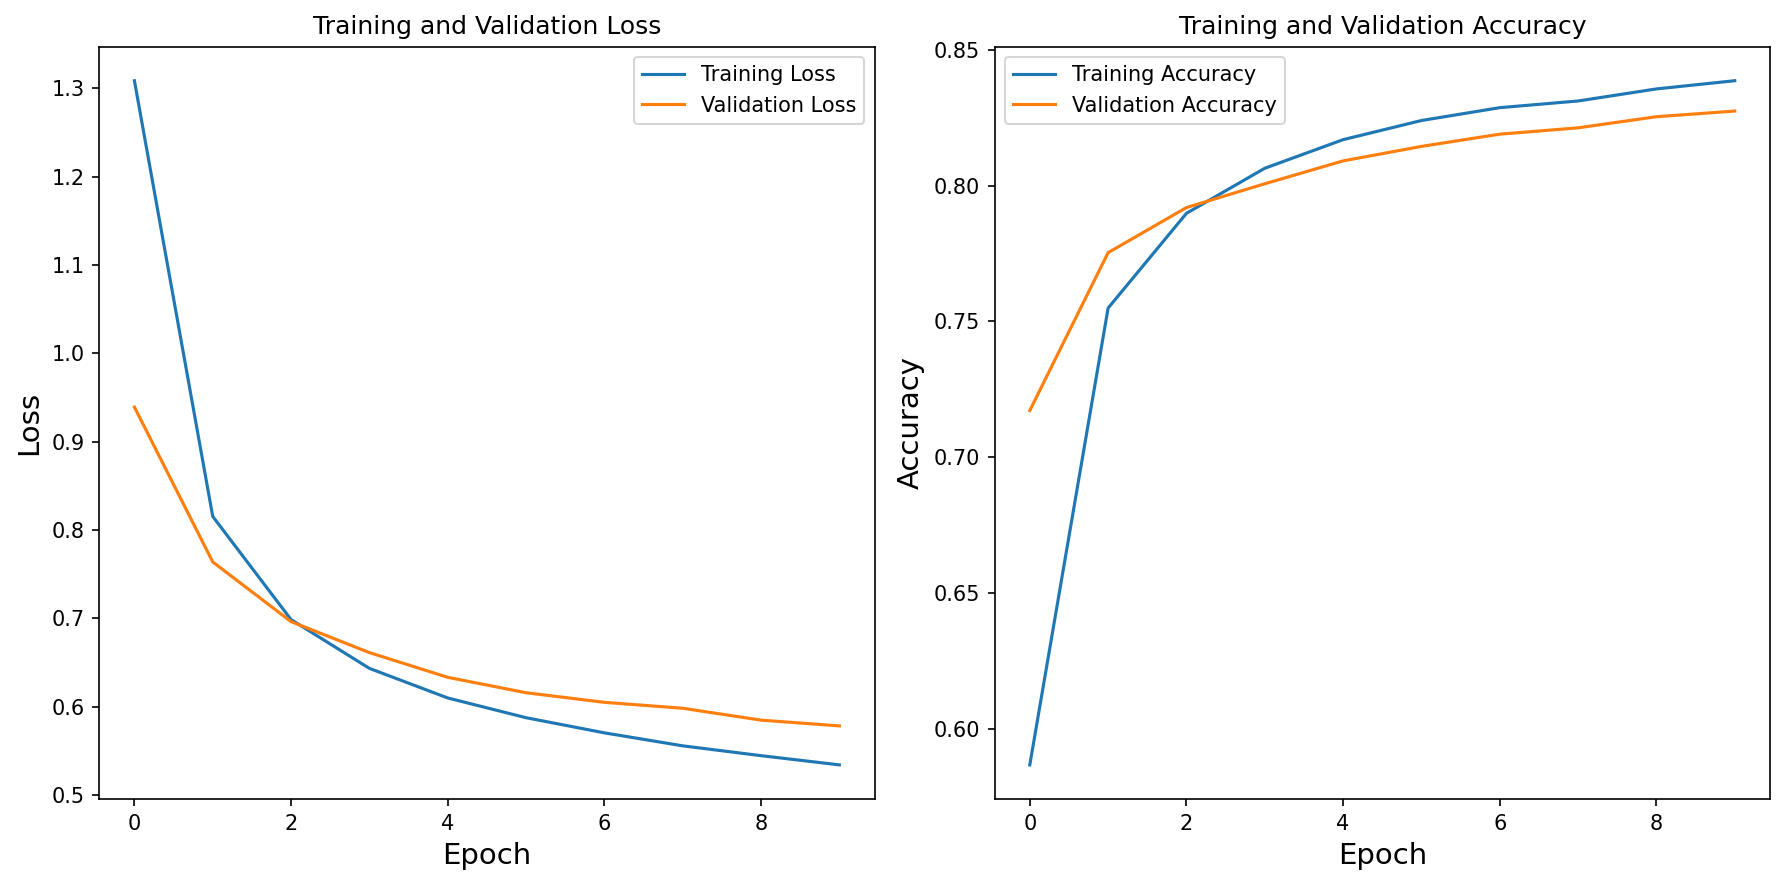

Test Accuracy 69.4%


In [10]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Our initial model had an accuracy of 84.2% after 10 epochs.  Let us explore differences with number of training epochs, number of hidden layers, size of initial hidden layers, and the optimizer.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3584 - loss: 1.8077 - val_accuracy: 0.7358 - val_loss: 0.9040
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7463 - loss: 0.8492 - val_accuracy: 0.7760 - val_loss: 0.7612
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7874 - loss: 0.7113 - val_accuracy: 0.7942 - val_loss: 0.6940
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.7998 - loss: 0.6605 - val_accuracy: 0.8021 - val_loss: 0.6583
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.8105 - loss: 0.6272 - val_accuracy: 0.8071 - val_loss: 0.6468
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.8165 - loss: 0.6133 - val_accuracy: 0.8102 - val_loss: 0.6322
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.8246 - loss: 0.5900 - val_accuracy: 0.8169 - val_loss: 0.6168
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.8285 - loss: 0.5724 - va

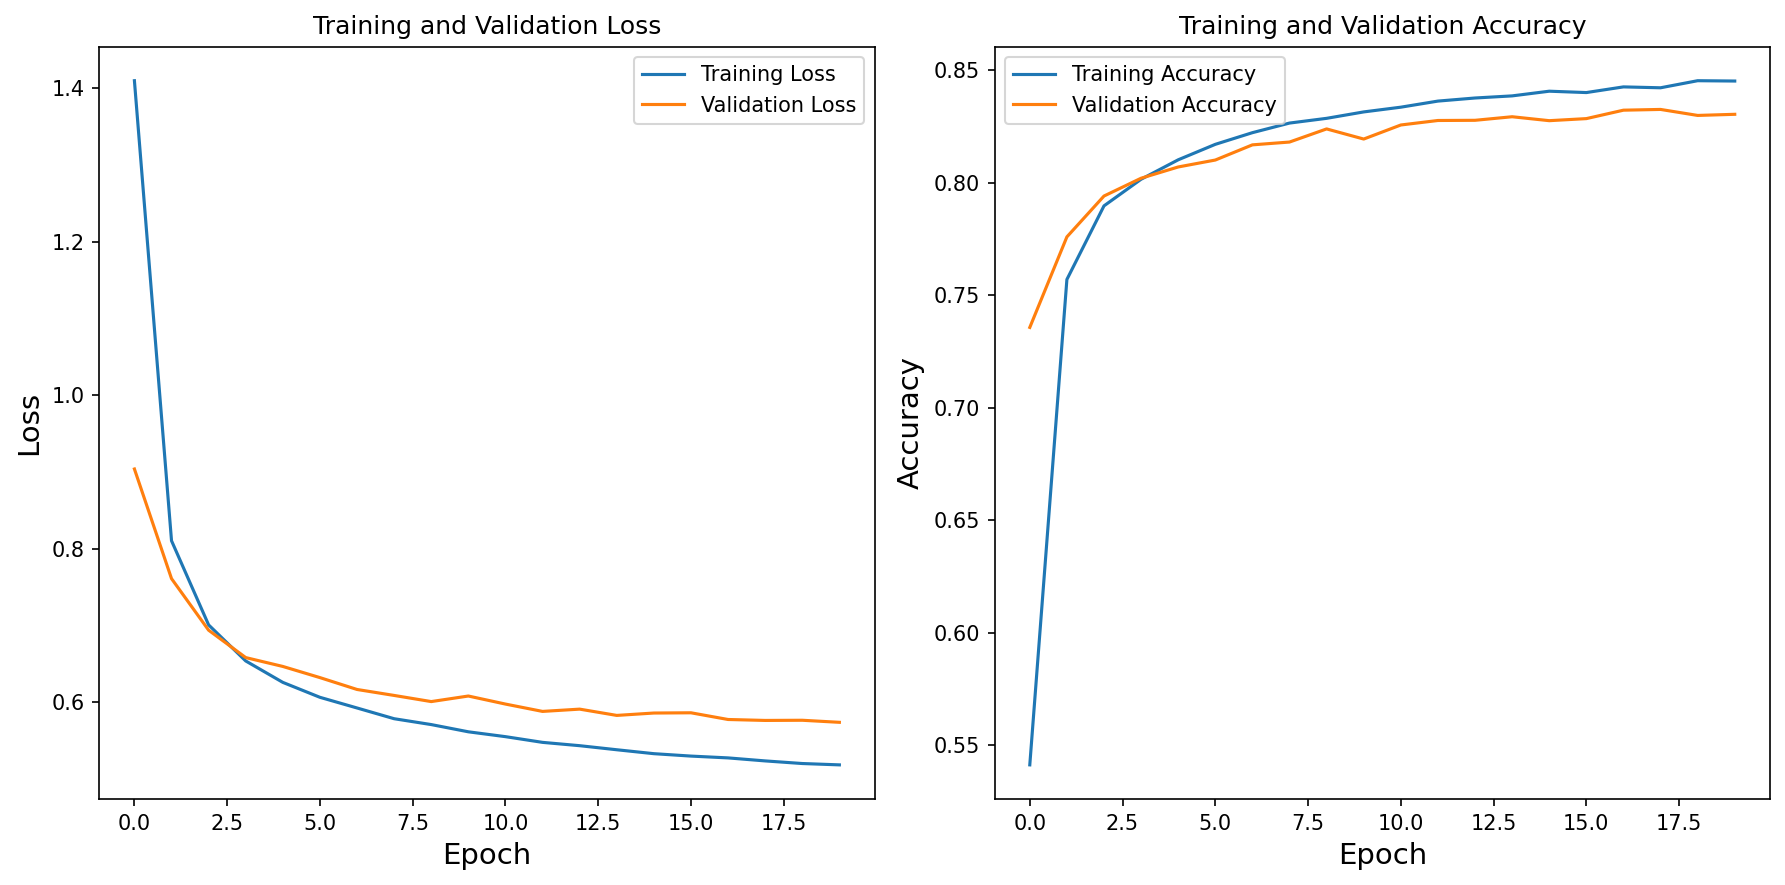

Test Accuracy 69.4%


In [11]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Doubling the number of epochs barely increased the model accuracy to 84.5% and we can also see that the validation accuracy stopped growing.

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           7,850 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,850 (30.66 KB)

 Trainable params: 7,850 (30.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6318 - loss: 1.2439 - val_accuracy: 0.7980 - val_loss: 0.6997
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8073 - loss: 0.6660 - val_accuracy: 0.8133 - val_loss: 0.6486
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.8153 - loss: 0.6174 - val_accuracy: 0.8173 - val_loss: 0.6353
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.8243 - loss: 0.5961 - val_accuracy: 0.8215 - val_loss: 0.6236
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.8259 - loss: 0.5883 - val_accuracy: 0.8209 - val_loss: 0.6174
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.8284 - loss: 0.5750 - val_accuracy: 0.8237 - val_loss: 0.6140
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.8296 - loss: 0.5795 - val_accuracy: 0.8253 - val_loss: 0.6100
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.8330 - loss: 0.5696 - va

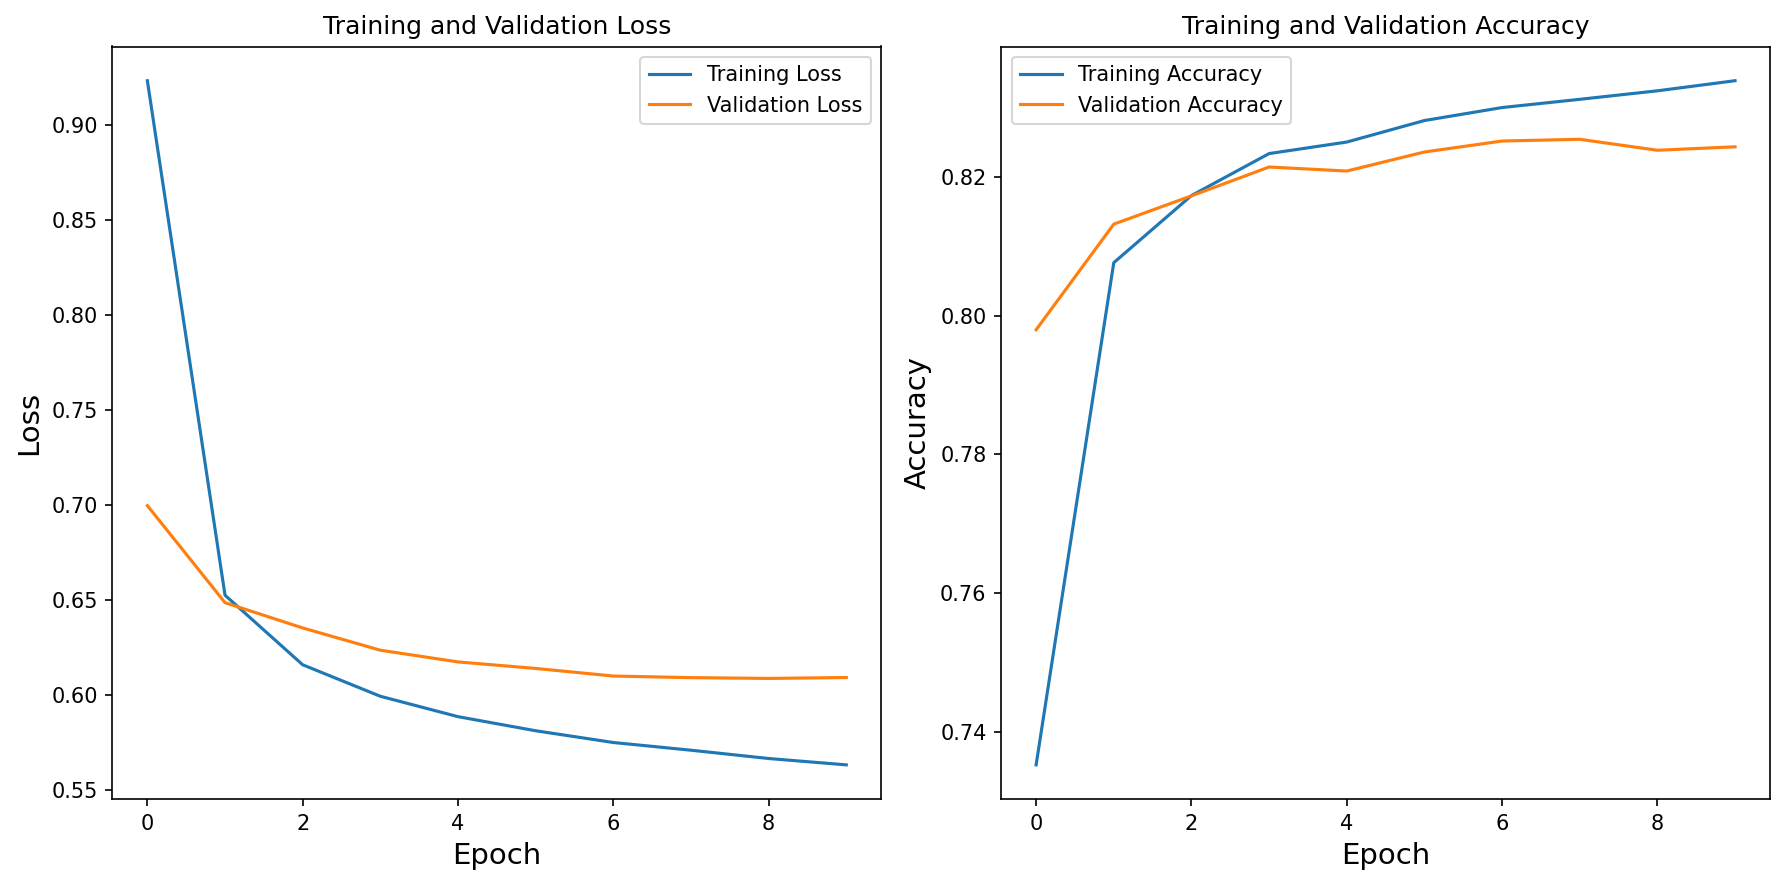

Test Accuracy 69.7%


In [12]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Having no hidden layers was able to get an accuracy of 83.4%.  This was a suprising result.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,586 (25.73 KB)

 Trainable params: 6,586 (25.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3552 - loss: 1.8480 - val_accuracy: 0.7173 - val_loss: 0.9562
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.7430 - loss: 0.8601 - val_accuracy: 0.7734 - val_loss: 0.7692
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.7841 - loss: 0.7195 - val_accuracy: 0.7893 - val_loss: 0.7041
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7973 - loss: 0.6751 - val_accuracy: 0.7932 - val_loss: 0.6891
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.8082 - loss: 0.6313 - val_accuracy: 0.8052 - val_loss: 0.6499
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.8180 - loss: 0.6031 - val_accuracy: 0.8053 - val_loss: 0.6545
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8221 - loss: 0.5930 - val_accuracy: 0.8175 - val_loss: 0.6232
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.8260 - loss: 0.5751 - val_

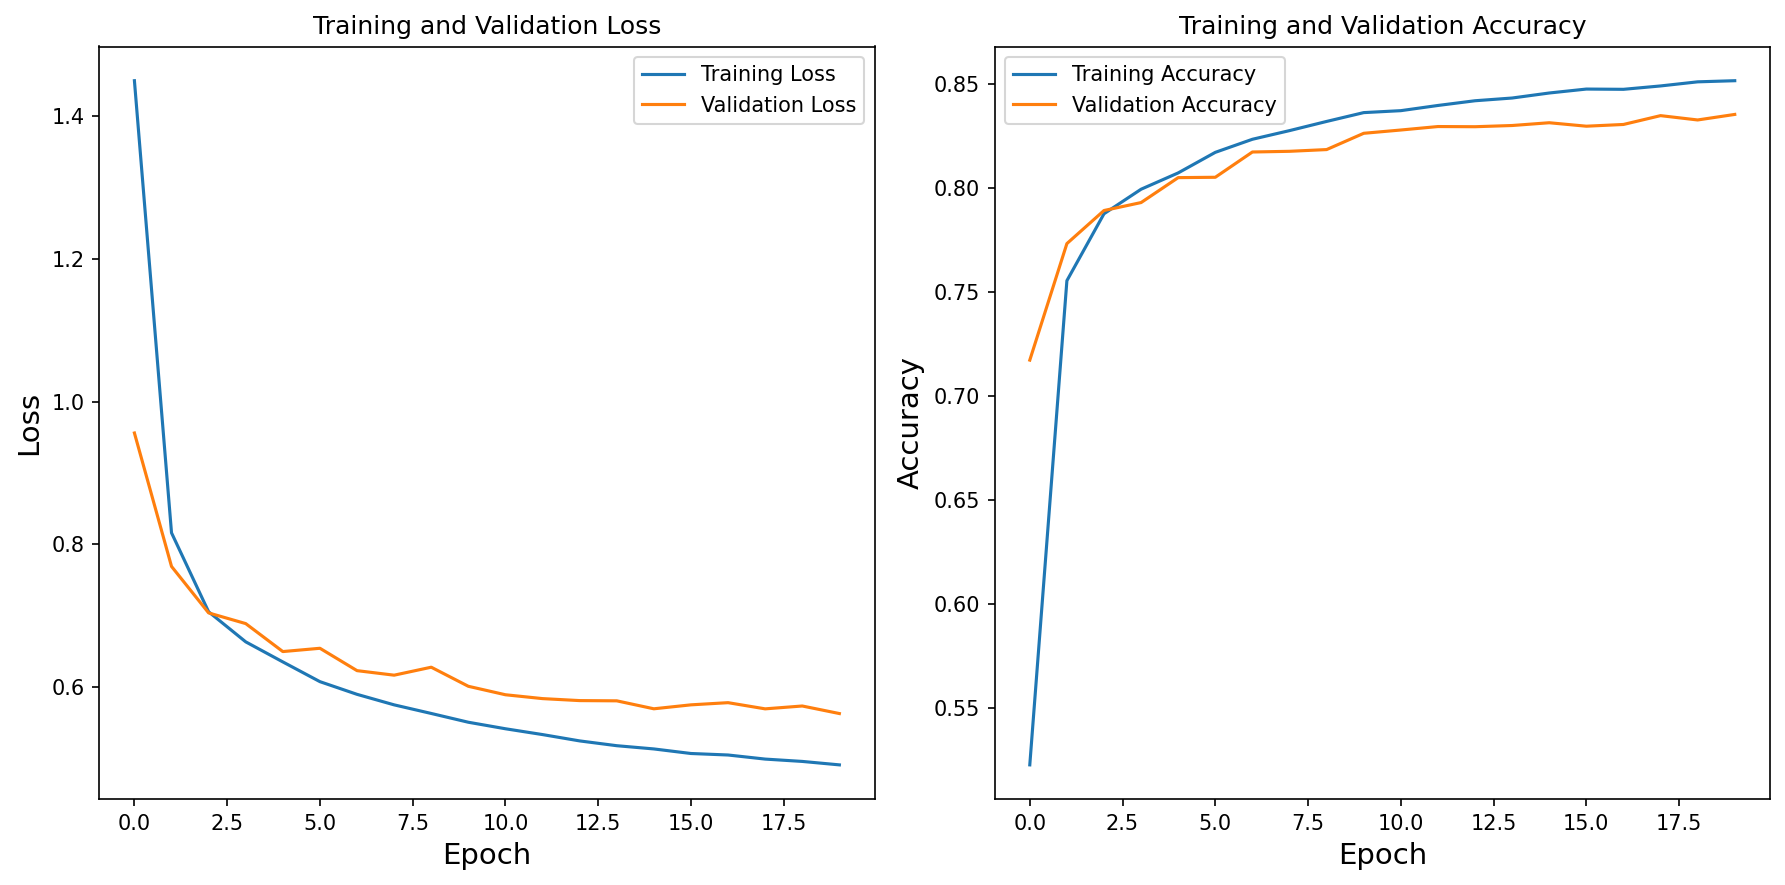

Test Accuracy 71.3%


In [13]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

A network with four hidden layers and using 20 epochs was able to get an accuracy of 85.4% but only had an accuracy of 83.6% by epoch 10.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,002 (429.70 KB)

 Trainable params: 110,002 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4366 - loss: 1.4973 - val_accuracy: 0.8703 - val_loss: 0.4693
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8931 - loss: 0.3722 - val_accuracy: 0.9115 - val_loss: 0.3135
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9308 - loss: 0.2416 - val_accuracy: 0.9285 - val_loss: 0.2550
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9515 - loss: 0.1741 - val_accuracy: 0.9333 - val_loss: 0.2378
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9632 - loss: 0.1333 - val_accuracy: 0.9408 - val_loss: 0.2225
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9698 - loss: 0.1081 - val_accuracy: 0.9433 - val_loss: 0.2129
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9755 - loss: 0.0884 - val_accuracy: 0.9428 - val_loss: 0.2197
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9822 - loss: 0.0649 - val_accuracy: 0.

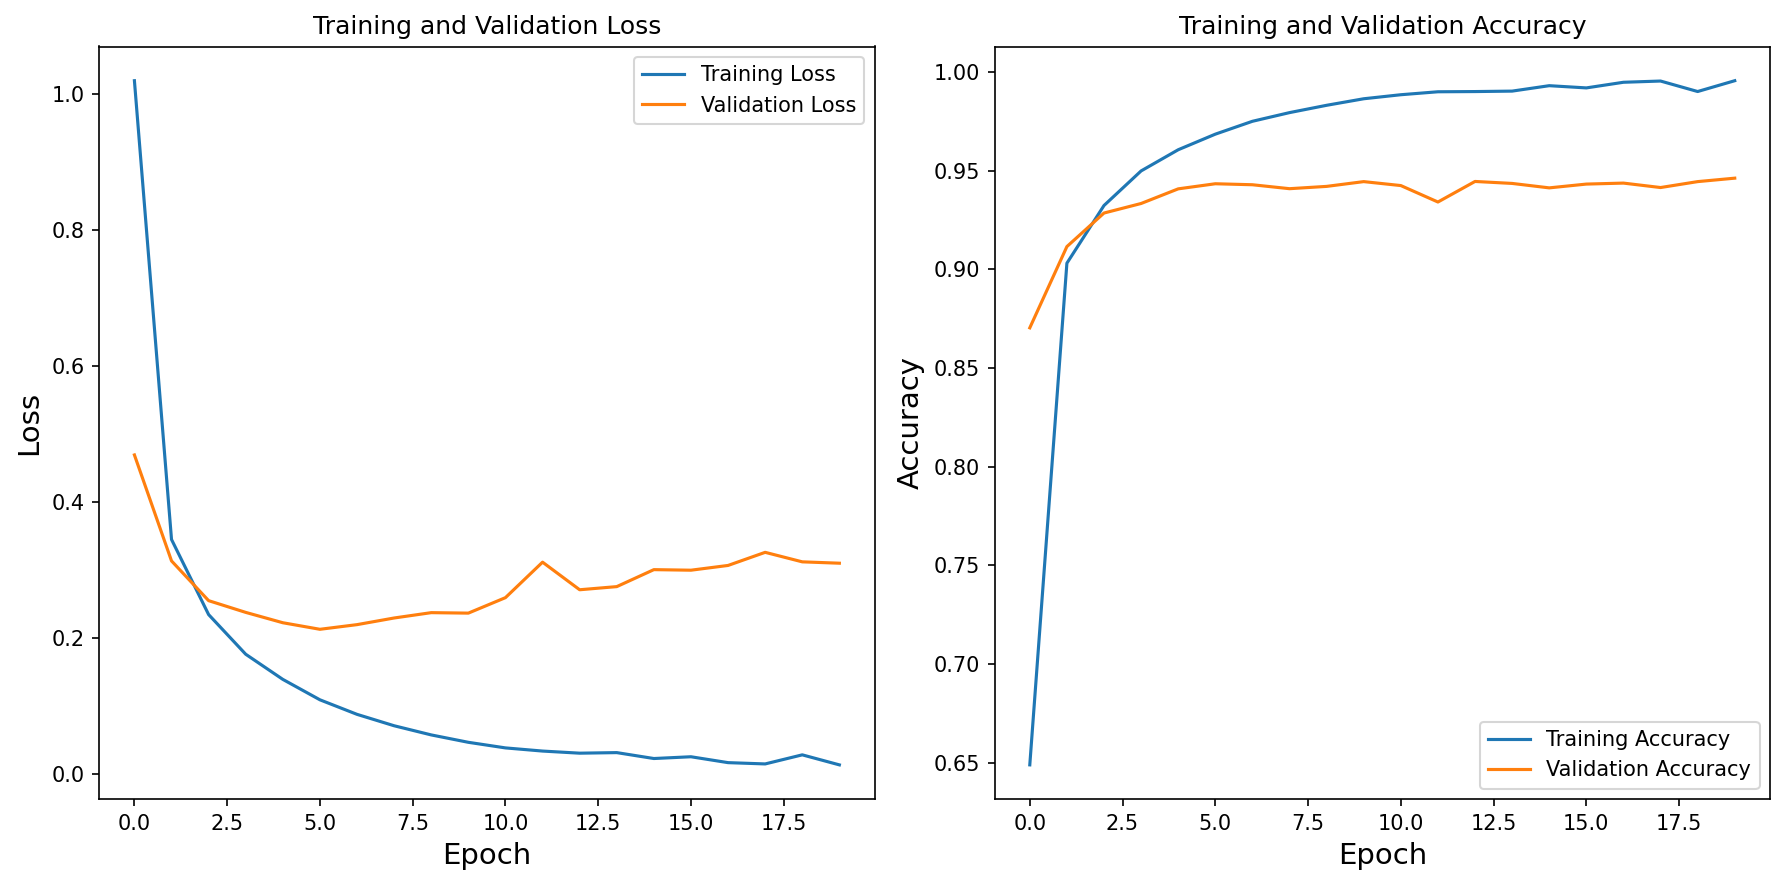

Test Accuracy 88.0%


In [14]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

A network with four hidden layers going from 128 -> 64 -> 16 -> 8 was able to get to 99.6% accuracy in 20 epochs was already at 93.0% by epoch 3 (and 98.8% by epoch 10).  However, looking at the graphs we see that we pretty much started overfitting after the 3rd epoch.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3273 - loss: 1.9726 - val_accuracy: 0.5716 - val_loss: 1.3517
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.6056 - loss: 1.2288 - val_accuracy: 0.6839 - val_loss: 1.0595
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6995 - loss: 1.0005 - val_accuracy: 0.7268 - val_loss: 0.9387
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7323 - loss: 0.8956 - val_accuracy: 0.7477 - val_loss: 0.8670
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7563 - loss: 0.8258 - val_accuracy: 0.7627 - val_loss: 0.8158
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7683 - loss: 0.7775 - val_accuracy: 0.7684 - val_loss: 0.7807
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7779 - loss: 0.7379 - val_accuracy: 0.7760 - val_loss: 0.7558
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.7875 - loss: 0.7095 - va

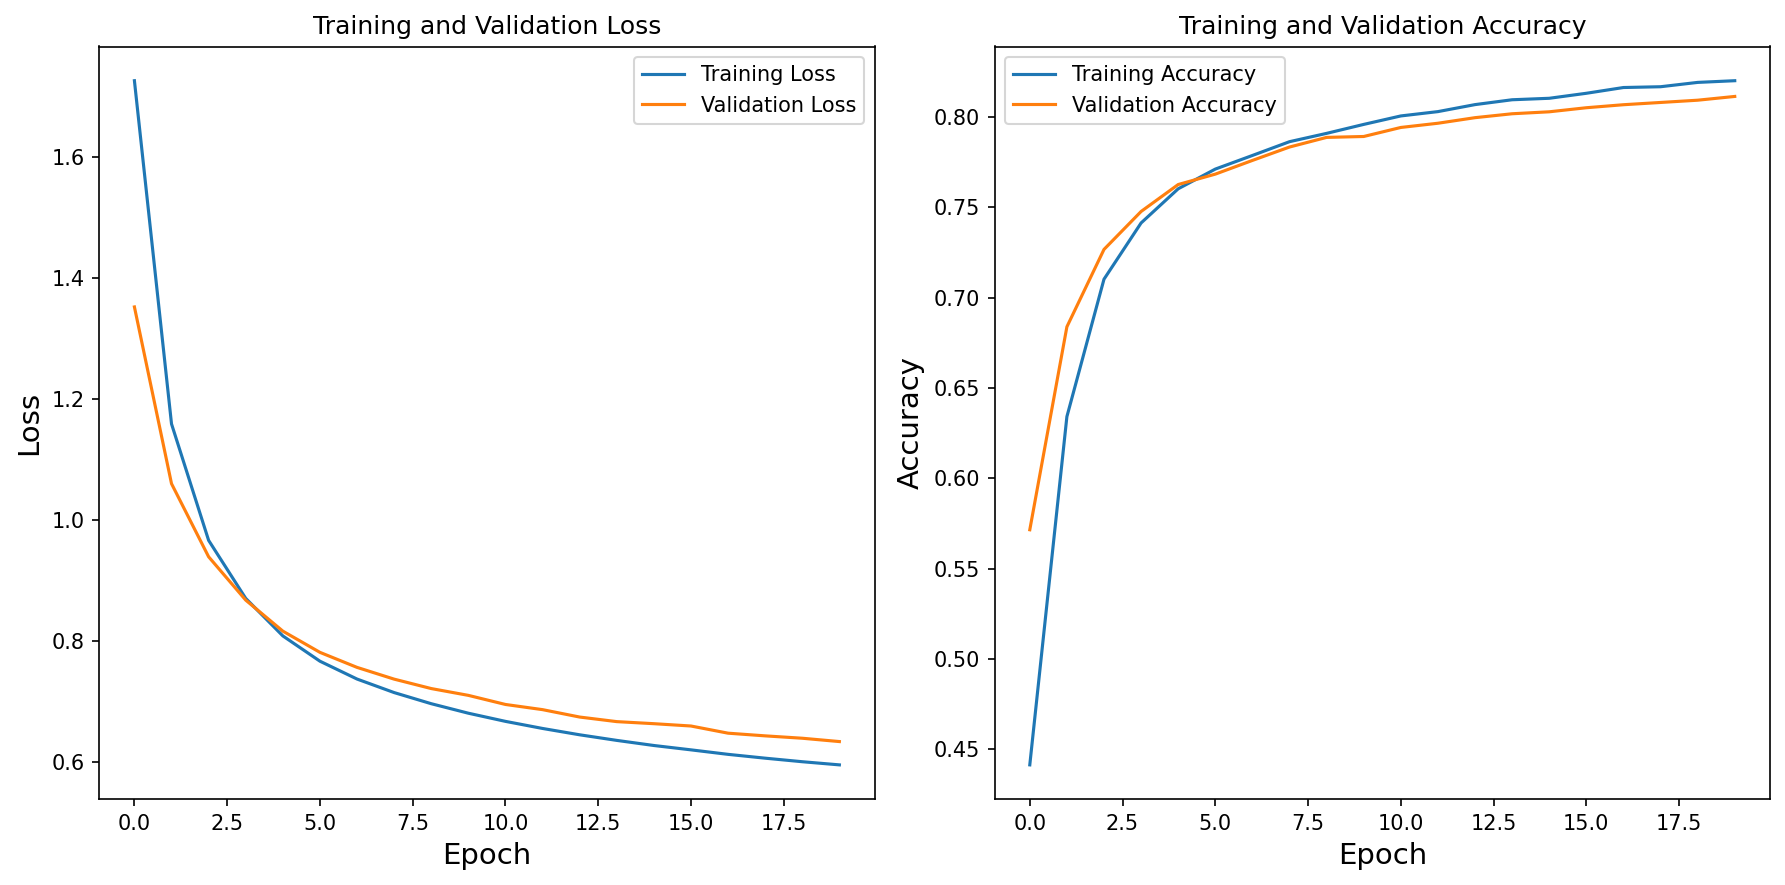

Test Accuracy 66.8%


In [15]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Going back to the original network structure of two dense 8 node layers, we have switched the optimizer to `adamax`.  This only got an 82.3% accuracy by epoch 20 and only 79.4% by epoch 10.  However, it appeared to have a great accuracy vs. validation curve.  That didn't matter for the resulting 66.8% test accuracy.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 8)                   │           6,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442 (25.16 KB)

 Trainable params: 6,442 (25.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1142 - loss: 2.2776 - val_accuracy: 0.2816 - val_loss: 2.0731
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.3255 - loss: 1.9589 - val_accuracy: 0.4502 - val_loss: 1.6543
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.4739 - loss: 1.5796 - val_accuracy: 0.5834 - val_loss: 1.3674
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5981 - loss: 1.3025 - val_accuracy: 0.6382 - val_loss: 1.1802
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.6455 - loss: 1.1392 - val_accuracy: 0.6718 - val_loss: 1.0651
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6809 - loss: 1.0282 - val_accuracy: 0.7018 - val_loss: 0.9823
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7084 - loss: 0.9440 - val_accuracy: 0.7224 - val_loss: 0.9214
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7303 - loss: 0.8901 - va

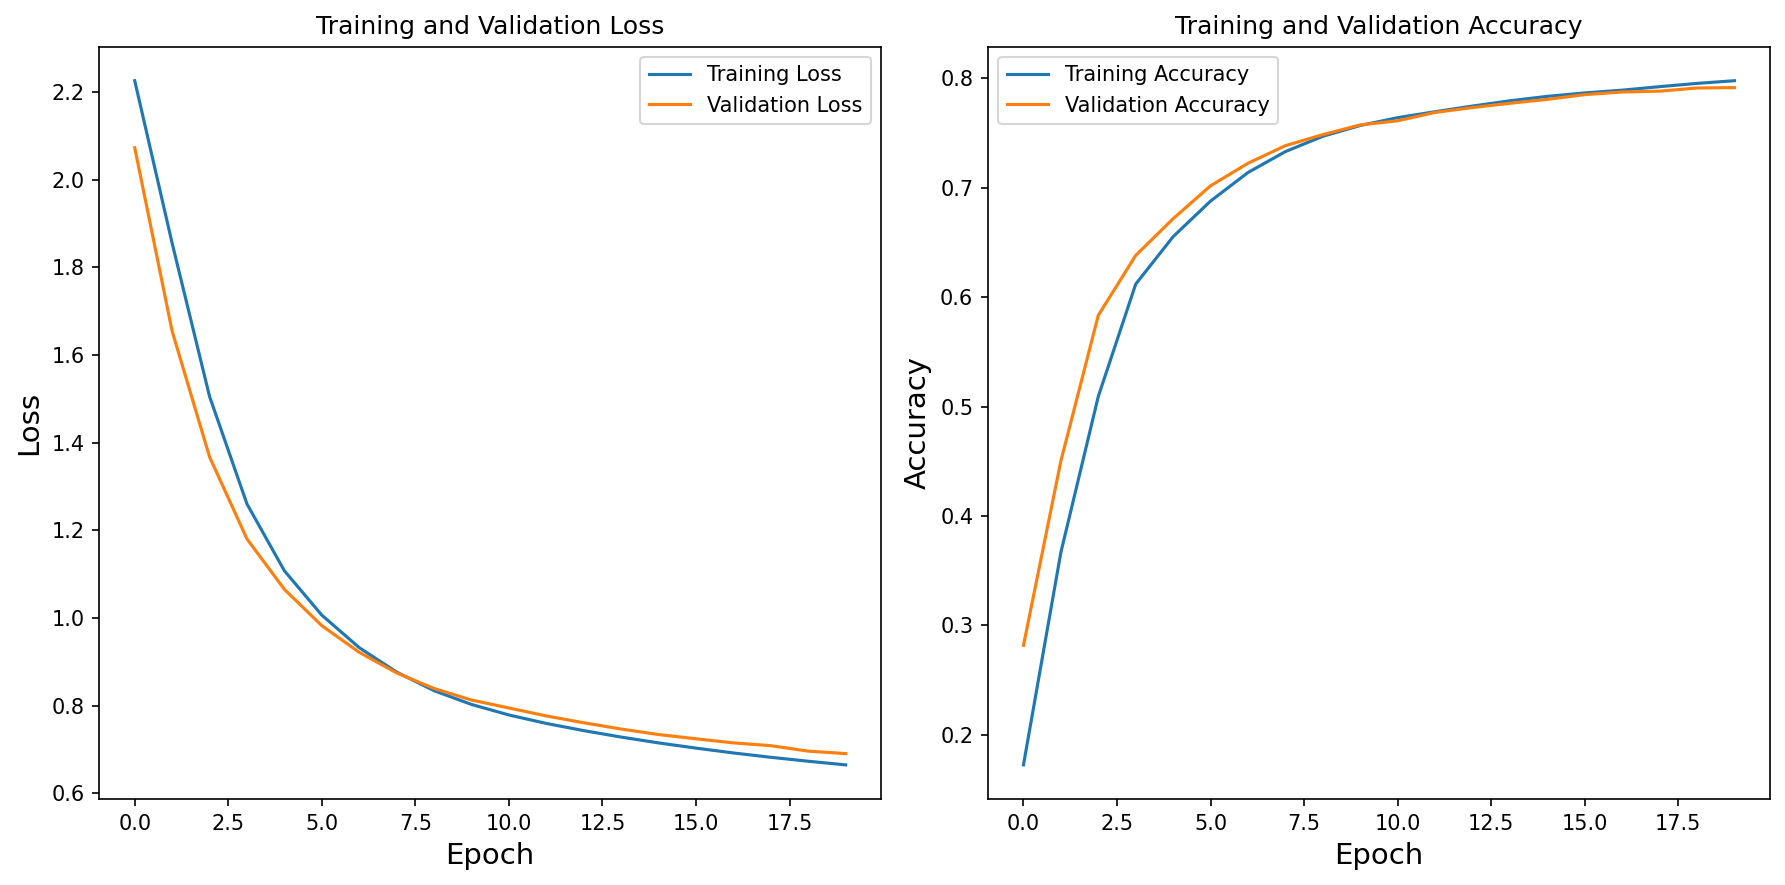

Test Accuracy 64.6%


In [16]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=20, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

The SGD optimizer performed even worse with a final accuracy of 79.9% at epoch 20 and only 75.5% at epoch 10.

Let us go back to the best model but lower the epochs to 3 to prevent overfitting and try it against our test dataset.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 10)                  │              90 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,002 (429.70 KB)

 Trainable params: 110,002 (429.70 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6016 - loss: 1.2011 - val_accuracy: 0.8752 - val_loss: 0.4311
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9010 - loss: 0.3489 - val_accuracy: 0.9148 - val_loss: 0.2989
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9369 - loss: 0.2211 - val_accuracy: 0.9332 - val_loss: 0.2412


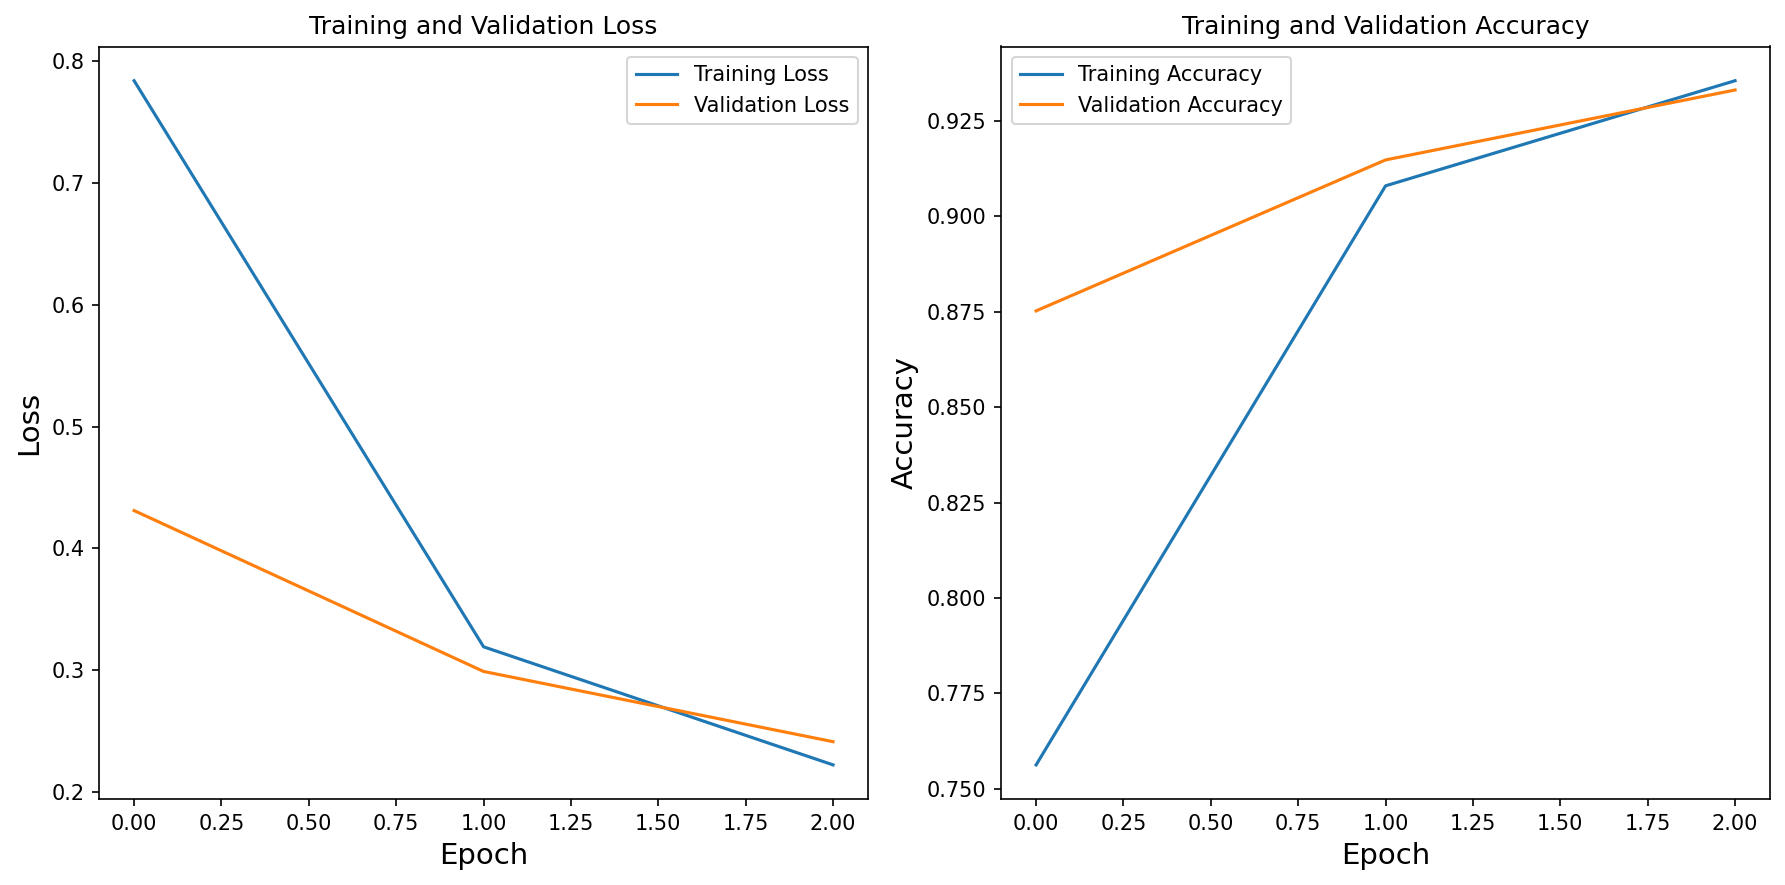

Test Accuracy 84.3%


In [17]:
model = Sequential([
    Input(shape=(28,28,1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=3, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


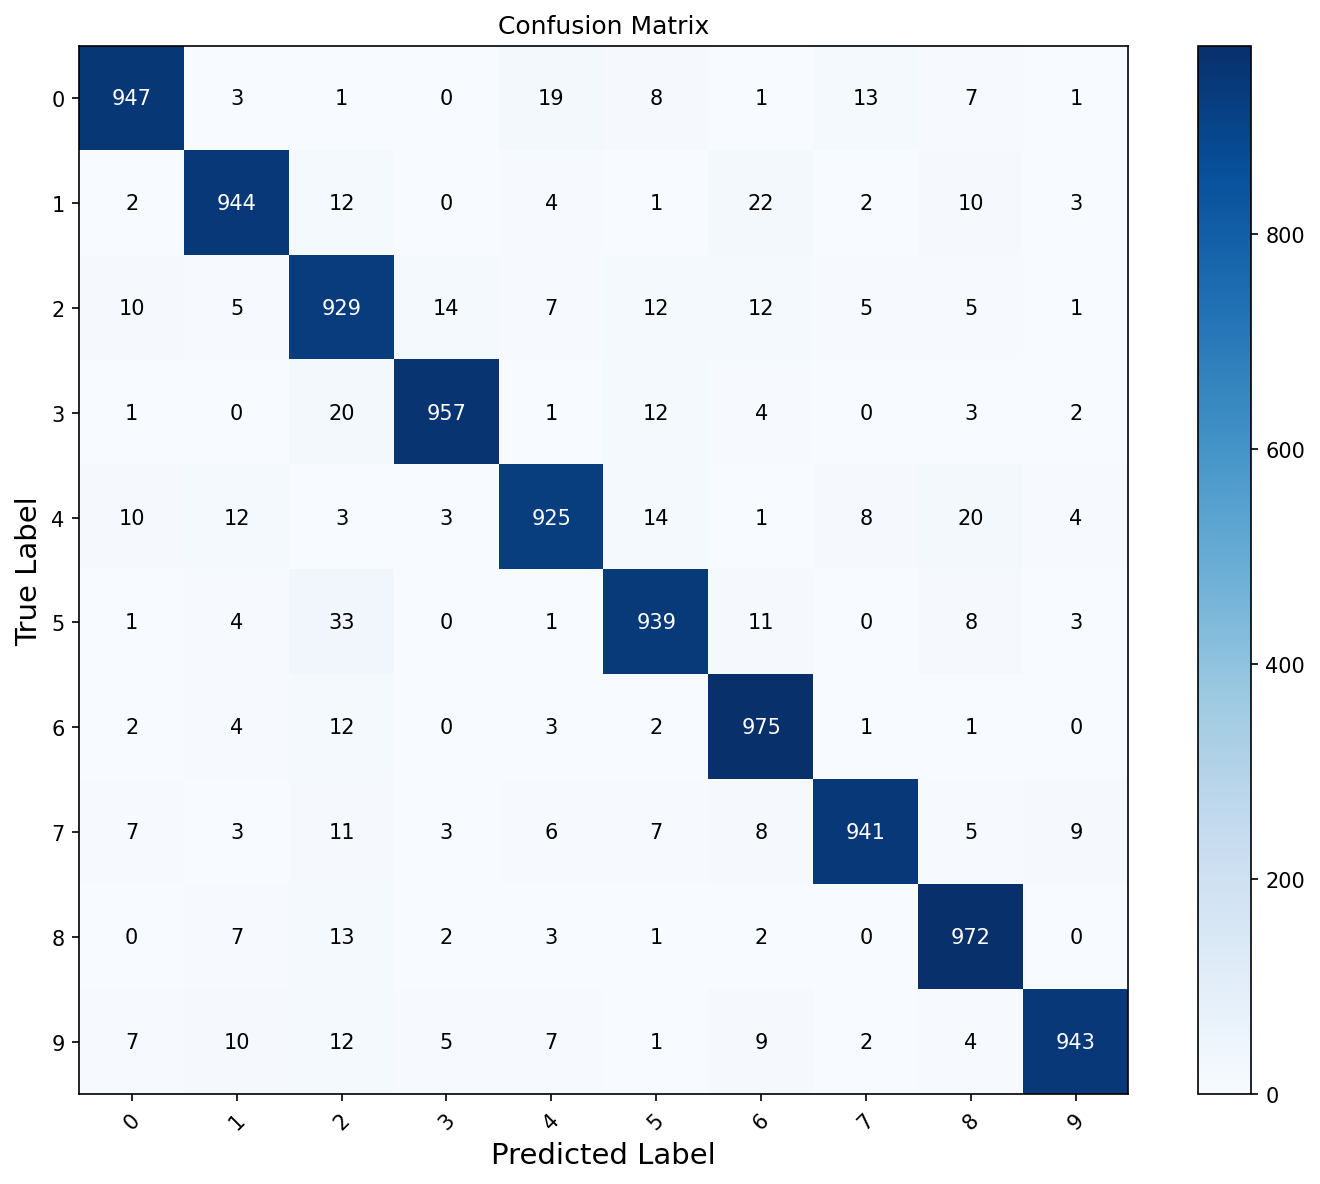

In [30]:
plot_confusion_matrix(model);

We had an overall testing accuracy of 84.3% which is not too bad.  But we are always looking for 100%!  Let us now explore how CNNs perform.

## CNNs

Let us start with a CNN with 2 conv layers, 1 max pooling layer, a flatten layer, 2 dense layers of size 128/64, and a 10 node output layer.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7699 - loss: 0.7599 - val_accuracy: 0.9476 - val_loss: 0.1772
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9596 - loss: 0.1374 - val_accuracy: 0.9629 - val_loss: 0.1205
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9761 - loss: 0.0818 - val_accuracy: 0.9731 - val_loss: 0.0927
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9881 - loss: 0.0416 - val_accuracy: 0.9744 - val_loss: 0.0901
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9916 - loss: 0.0301 - val_accuracy: 0.9743 - val_loss: 0.0899
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9947 - loss: 0.0184 - val_accuracy: 0.9760 - val_loss: 0.0915
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9955 - loss: 0.0152 - val_accuracy: 0.9767 - val_loss: 0.0924
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9969 - loss: 0.0119 - val_accuracy: 0.

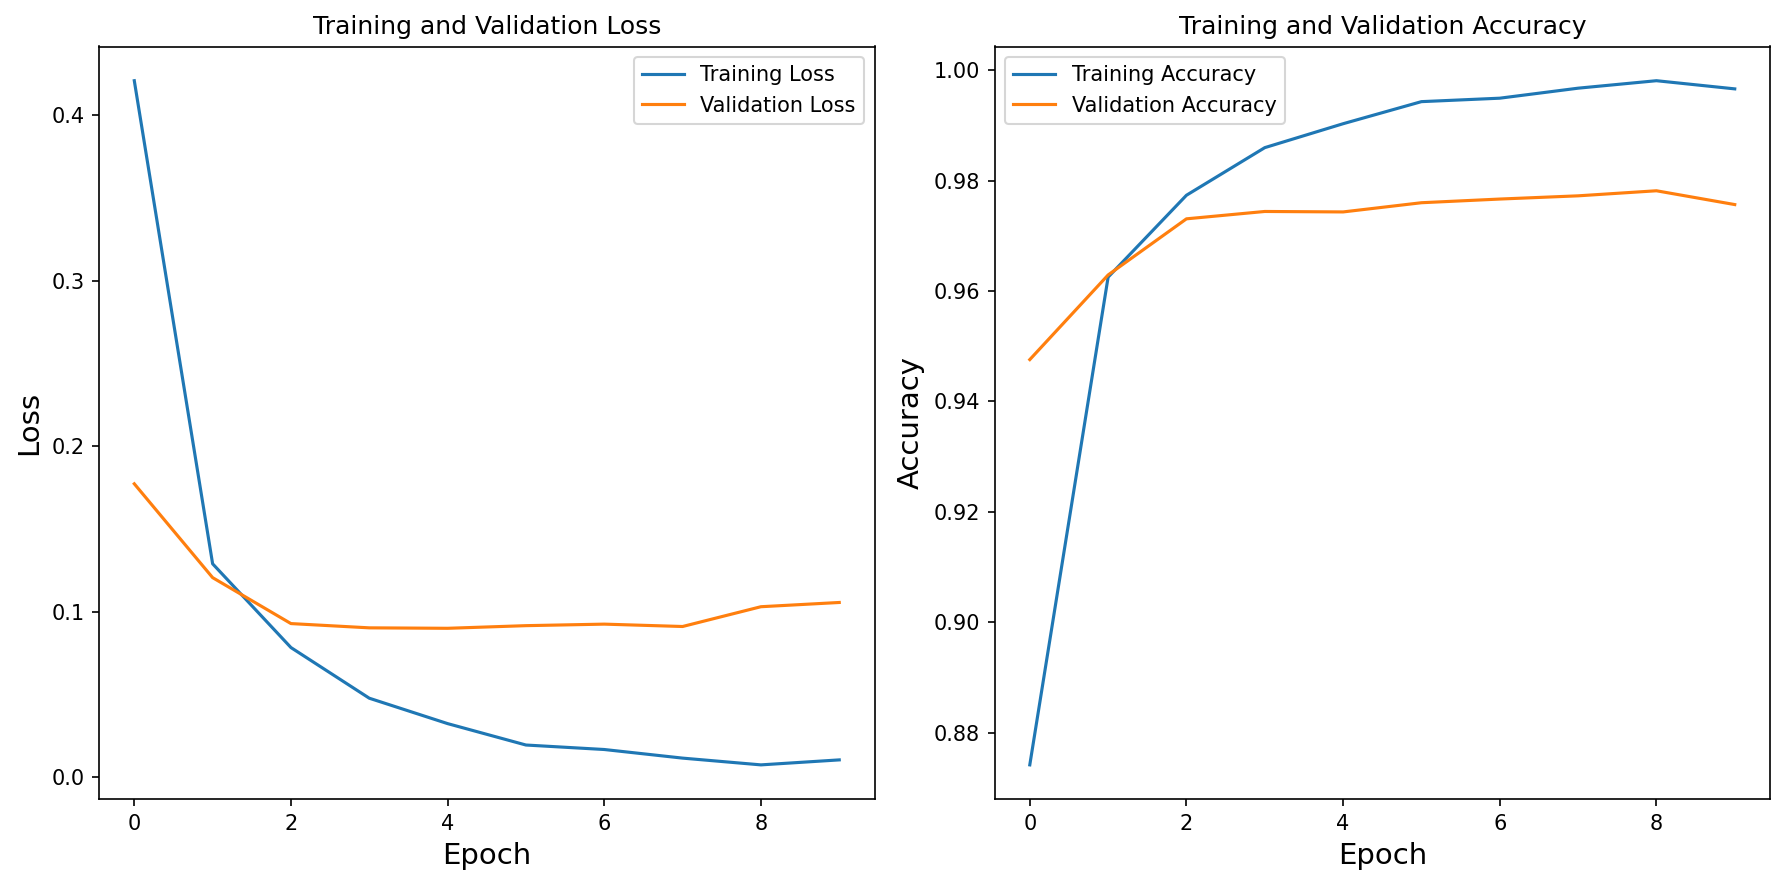

Test Accuracy 93.0%


In [19]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

We can see that our training model got up to 99.7% but topped out at around a 97.6% validation accuracy.  The testing results were 93.0% accurate which is already much better than our DNN.  We can also see that we topped out our performance around 3 epochs again.

Let us try some variations of the model configuration now and see if we can't optimize our performance.

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7353 - loss: 0.9114 - val_accuracy: 0.8990 - val_loss: 0.3324
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9103 - loss: 0.2987 - val_accuracy: 0.9267 - val_loss: 0.2386
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9416 - loss: 0.2020 - val_accuracy: 0.9446 - val_loss: 0.1911
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9566 - loss: 0.1482 - val_accuracy: 0.9532 - val_loss: 0.1549
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9653 - loss: 0.1175 - val_accuracy: 0.9560 - val_loss: 0.1490
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9724 - loss: 0.0952 - val_accuracy: 0.9602 - val_loss: 0.1335
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9773 - loss: 0.0775 - val_accuracy: 0.9653 - val_loss: 0.1225
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9820 - loss: 0.0621 - val_accuracy: 0.

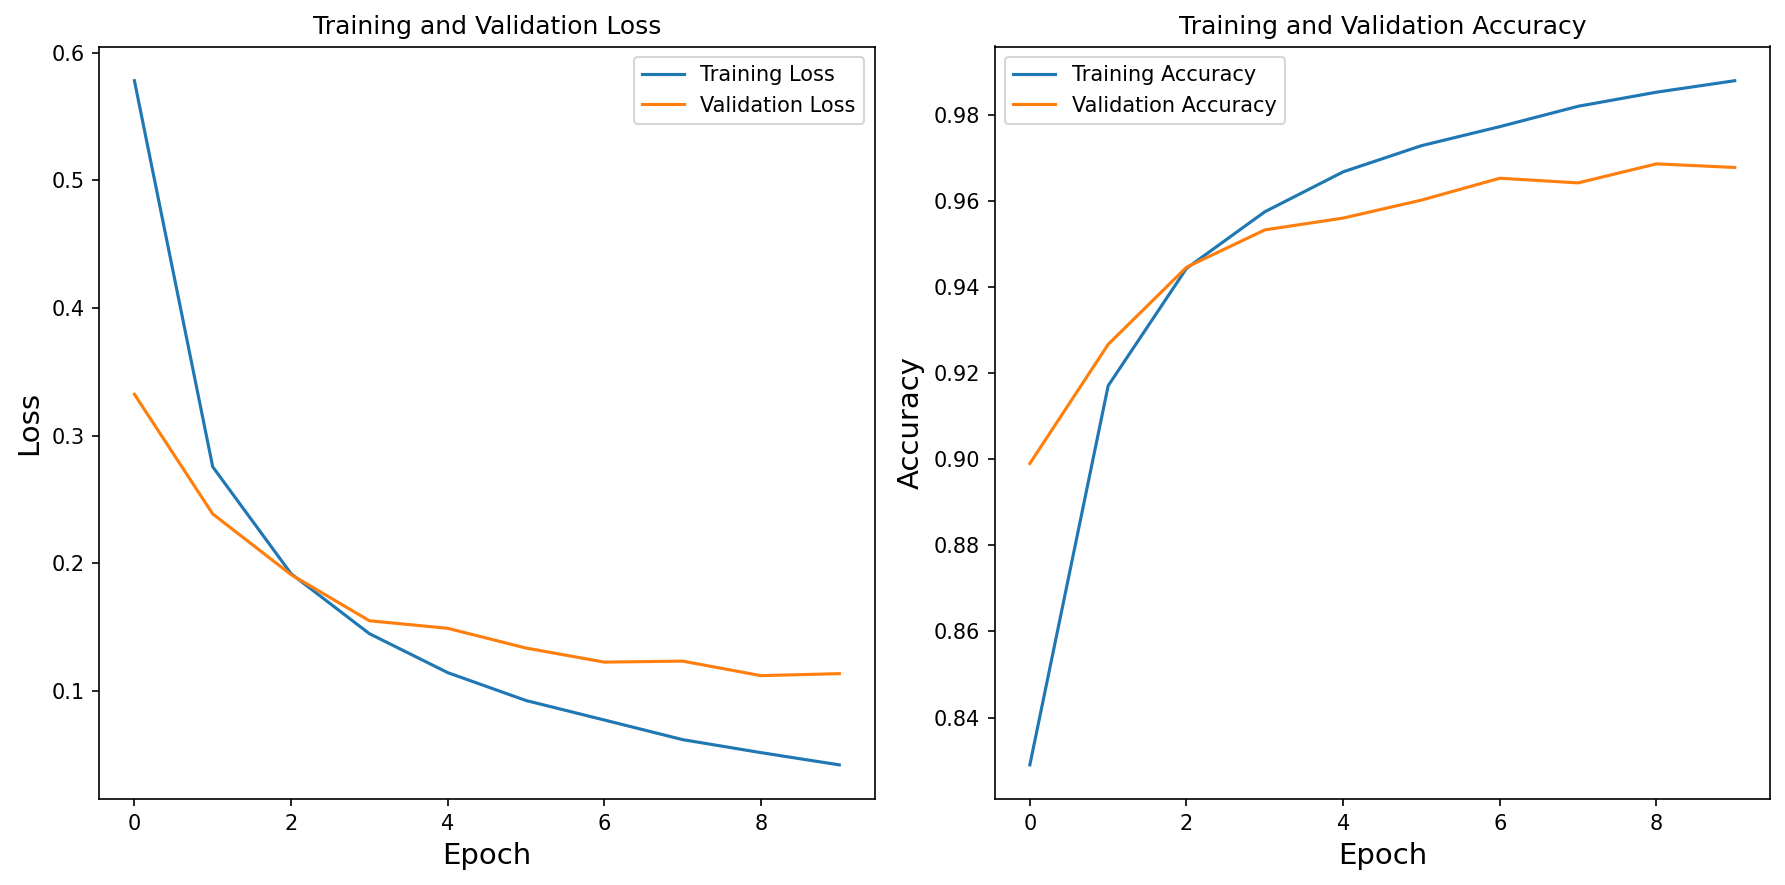

Test Accuracy 92.1%


In [20]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Using `adamax`, the training curves look better but the overall performance was slightly worse: only 92.1%.

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2051 - loss: 2.1056 - val_accuracy: 0.7943 - val_loss: 0.6879
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8298 - loss: 0.5692 - val_accuracy: 0.8737 - val_loss: 0.4256
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8795 - loss: 0.4006 - val_accuracy: 0.8967 - val_loss: 0.3447
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9028 - loss: 0.3197 - val_accuracy: 0.9126 - val_loss: 0.2953
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9155 - loss: 0.2791 - val_accuracy: 0.9206 - val_loss: 0.2689
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9253 - loss: 0.2455 - val_accuracy: 0.9168 - val_loss: 0.2787
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9298 - loss: 0.2292 - val_accuracy: 0.9296 - val_loss: 0.2364
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9373 - loss: 0.2067 - val_accuracy: 0.

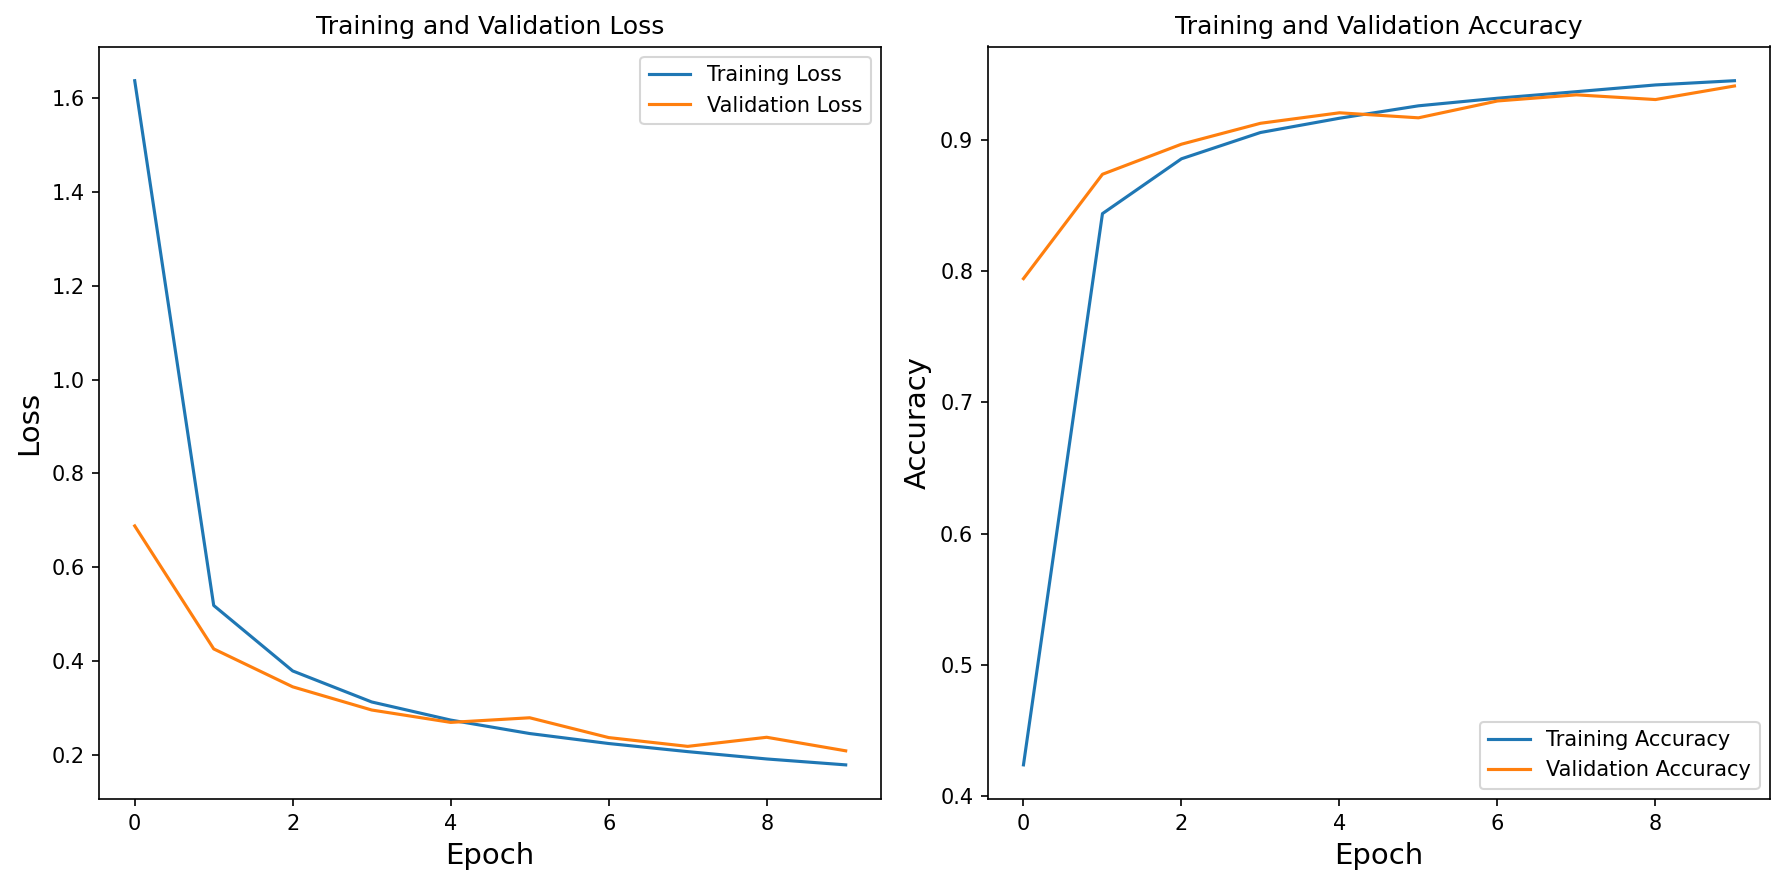

Test Accuracy 87.2%


In [21]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

SGD dropped way back down to only 87.2% accuracy.  It may have benefitted from more epochs but the difference in validation accuracy and testing accuracy leads me to believe it was still overfitting somehow.

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,194 (1.16 MB)

 Trainable params: 305,194 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7464 - loss: 0.8225 - val_accuracy: 0.9280 - val_loss: 0.2435
Epoch 2/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9514 - loss: 0.1699 - val_accuracy: 0.9578 - val_loss: 0.1421
Epoch 3/3
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9725 - loss: 0.0949 - val_accuracy: 0.9636 - val_loss: 0.1240


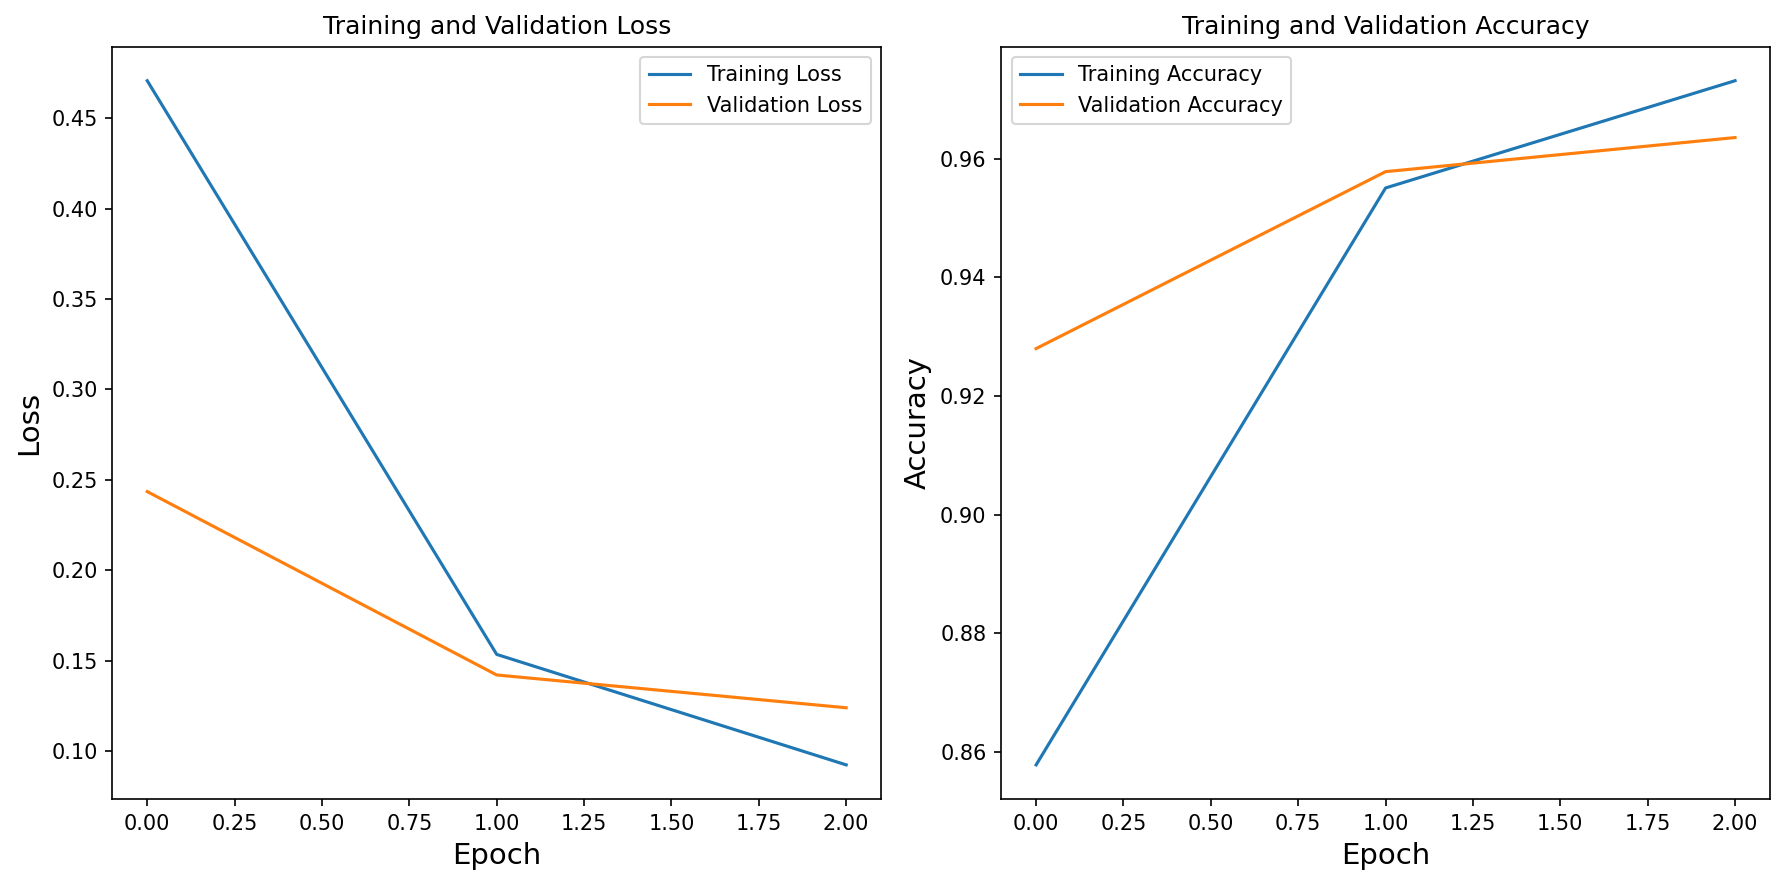

Test Accuracy 90.7%


In [22]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=3, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Just dropping the number of training epochs to 3 sped up training and only dropped test accuracy to 90.7%.

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 603,658 (2.30 MB)

 Trainable params: 603,658 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8024 - loss: 0.6508 - val_accuracy: 0.9572 - val_loss: 0.1434
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9684 - loss: 0.1064 - val_accuracy: 0.9697 - val_loss: 0.1040
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9836 - loss: 0.0528 - val_accuracy: 0.9707 - val_loss: 0.1000
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9902 - loss: 0.0340 - val_accuracy: 0.9726 - val_loss: 0.0968
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9932 - loss: 0.0208 - val_accuracy: 0.9734 - val_loss: 0.0963
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9962 - loss: 0.0135 - val_accuracy: 0.9747 - val_loss: 0.1083
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.9746 - val_loss: 0.1088
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9972 - loss: 0.0082 - val_accu

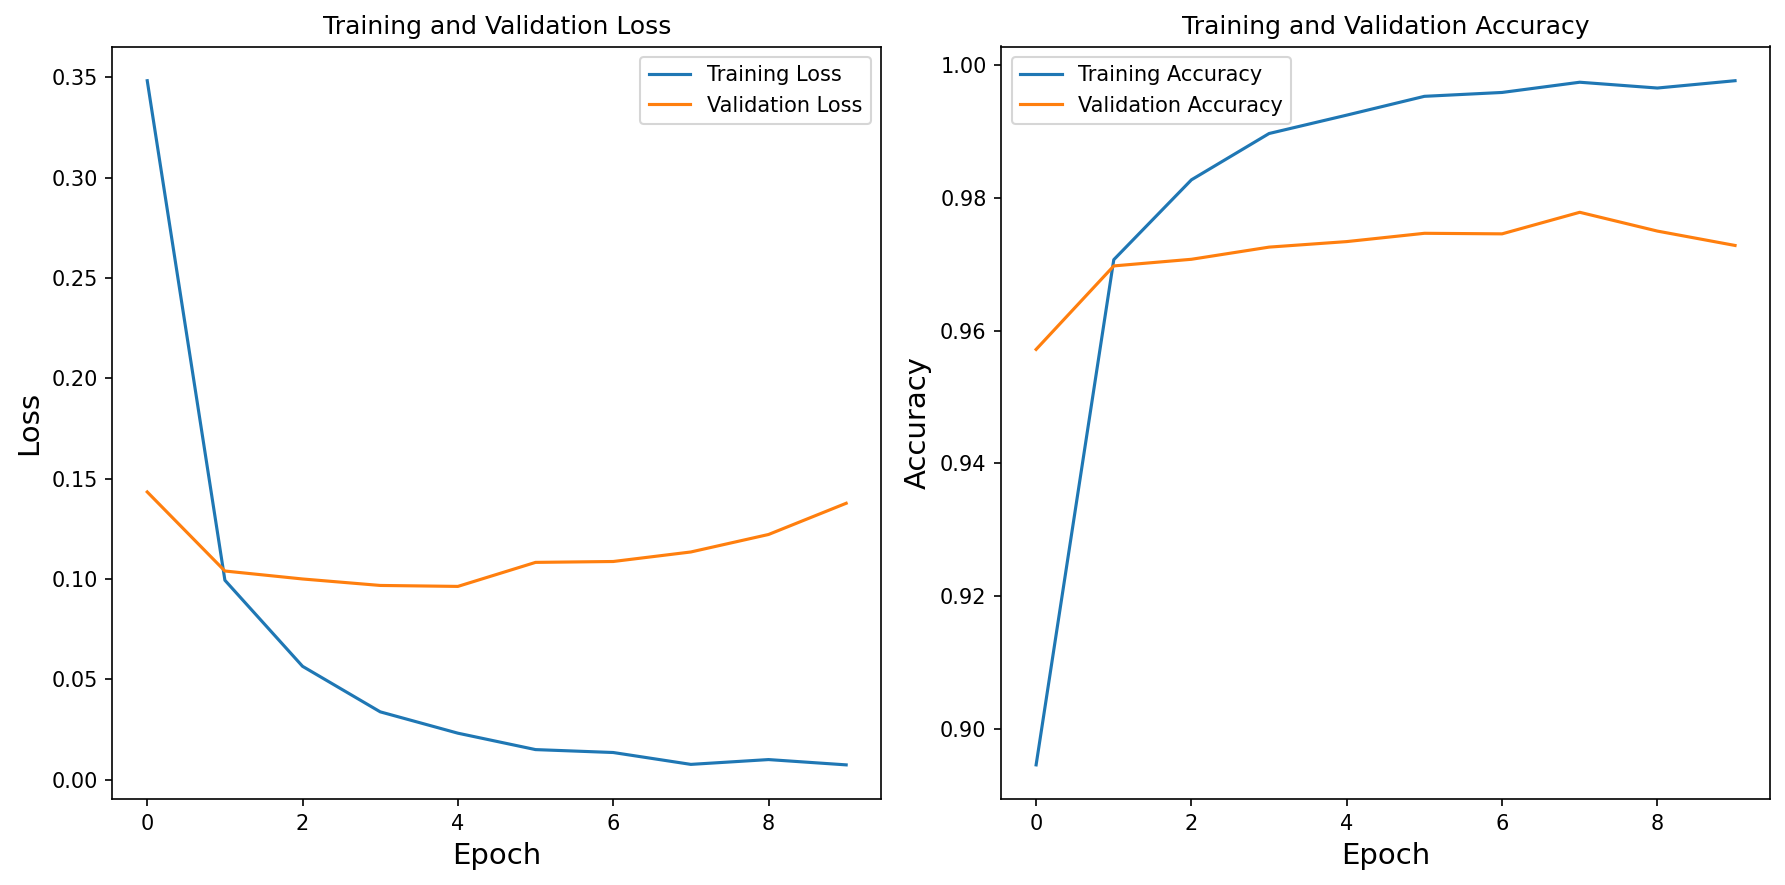

Test Accuracy 92.5%


In [23]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Doubling the number of kernels in each of the convolution layers improved performance to 92.5% but also doubled the number of parameters being learned.  It also would have benefitted from only 3 training epochs.

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 8)           │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 20, 20, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,258 (848.66 KB)

 Trainable params: 217,258 (848.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7518 - loss: 0.7687 - val_accuracy: 0.9442 - val_loss: 0.1886
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9575 - loss: 0.1422 - val_accuracy: 0.9635 - val_loss: 0.1215
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9750 - loss: 0.0867 - val_accuracy: 0.9707 - val_loss: 0.0974
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9834 - loss: 0.0549 - val_accuracy: 0.9682 - val_loss: 0.1052
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9887 - loss: 0.0373 - val_accuracy: 0.9690 - val_loss: 0.1113
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9910 - loss: 0.0279 - val_accuracy: 0.9706 - val_loss: 0.1149
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.9760 - val_loss: 0.0980
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9955 - loss: 0.0143 - val_accuracy: 0.

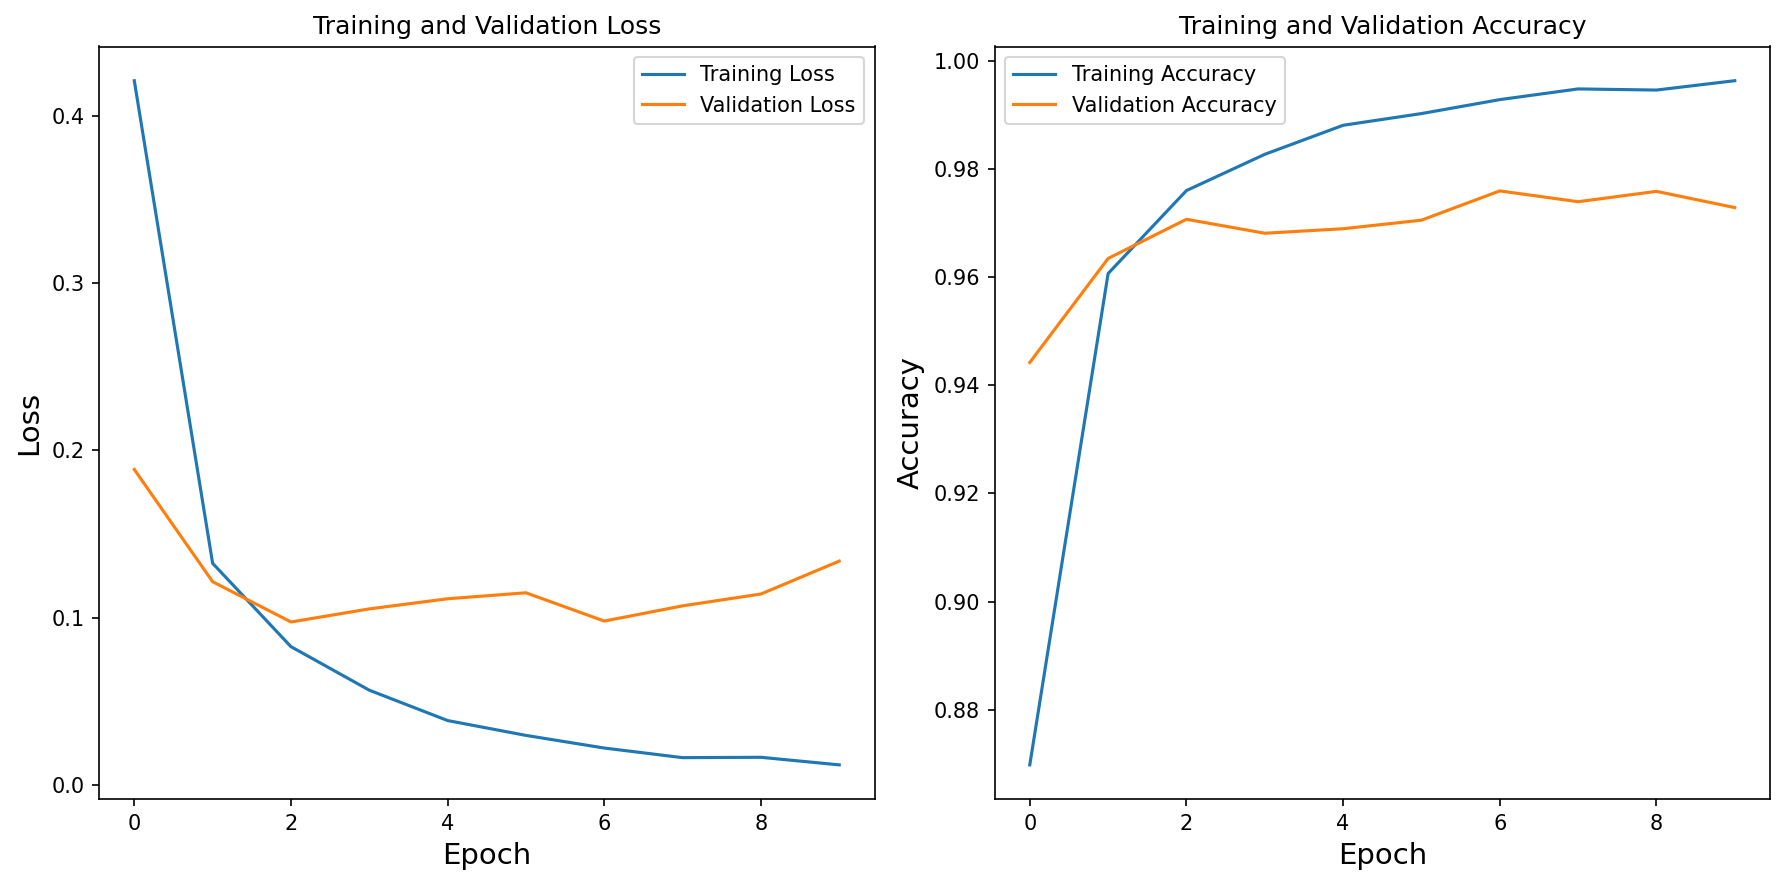

Test Accuracy 92.9%


In [24]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (5, 5), activation='relu'),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Increasing the size of the kernels for the convolution layers dropped the number of parameters by a third and improved performance to 92.9%.  It also would have benefitted from stopping after 3 epochs.

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,189,930 (4.54 MB)

 Trainable params: 1,189,930 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8009 - loss: 0.6563 - val_accuracy: 0.9503 - val_loss: 0.1738
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9632 - loss: 0.1287 - val_accuracy: 0.9657 - val_loss: 0.1193
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9804 - loss: 0.0622 - val_accuracy: 0.9603 - val_loss: 0.1336
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9889 - loss: 0.0358 - val_accuracy: 0.9630 - val_loss: 0.1311
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9922 - loss: 0.0233 - val_accuracy: 0.9713 - val_loss: 0.1167
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9964 - loss: 0.0126 - val_accuracy: 0.9716 - val_loss: 0.1245
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9959 - loss: 0.0129 - val_accuracy: 0.9696 - val_loss: 0.1335
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9966 - loss: 0.0111 - val_accu

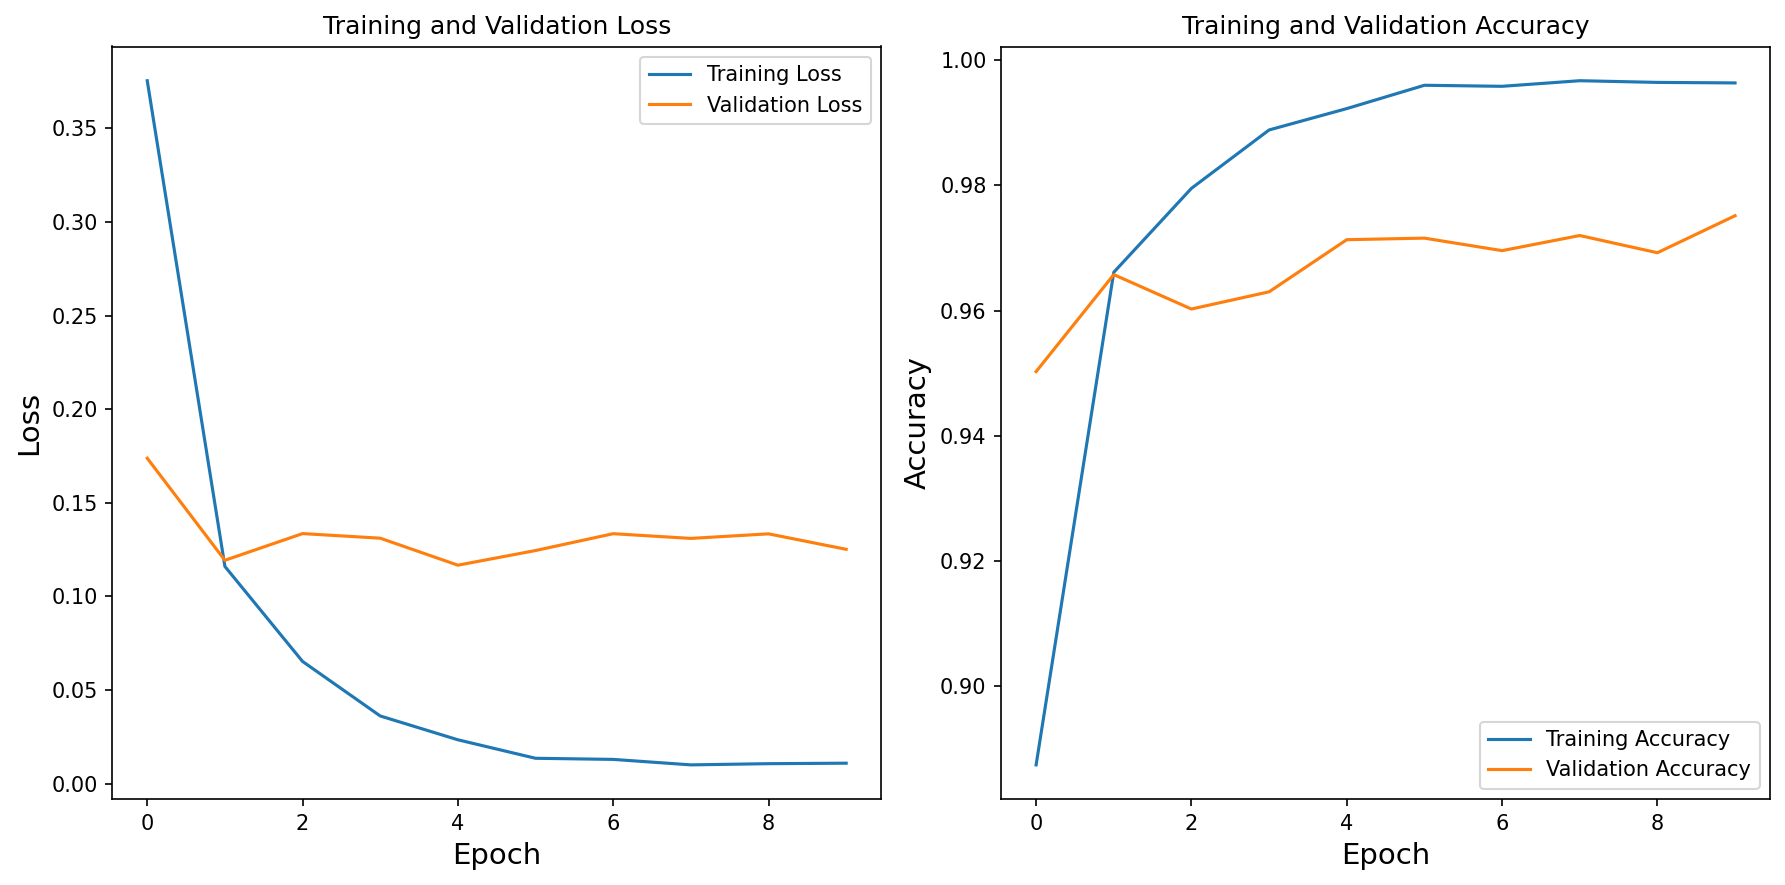

Test Accuracy 92.7%


In [25]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Removing the max pooling layer jumped the number of parameters by a factor of 4 (1.2M) and had an accuracy of 92.7%.  It seemed like it would have benefited from fewer epochs as well.

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 16)          │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 8, 8, 32)            │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,818 (343.04 KB)

 Trainable params: 87,818 (343.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6998 - loss: 0.9312 - val_accuracy: 0.9380 - val_loss: 0.2060
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9456 - loss: 0.1784 - val_accuracy: 0.9608 - val_loss: 0.1334
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9677 - loss: 0.1076 - val_accuracy: 0.9673 - val_loss: 0.1084
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9768 - loss: 0.0747 - val_accuracy: 0.9737 - val_loss: 0.0883
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9830 - loss: 0.0524 - val_accuracy: 0.9728 - val_loss: 0.0911
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9877 - loss: 0.0403 - val_accuracy: 0.9760 - val_loss: 0.0820
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9907 - loss: 0.0314 - val_accuracy: 0.9751 - val_loss: 0.0830
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9913 - loss: 0.0248 - val_accuracy: 0.

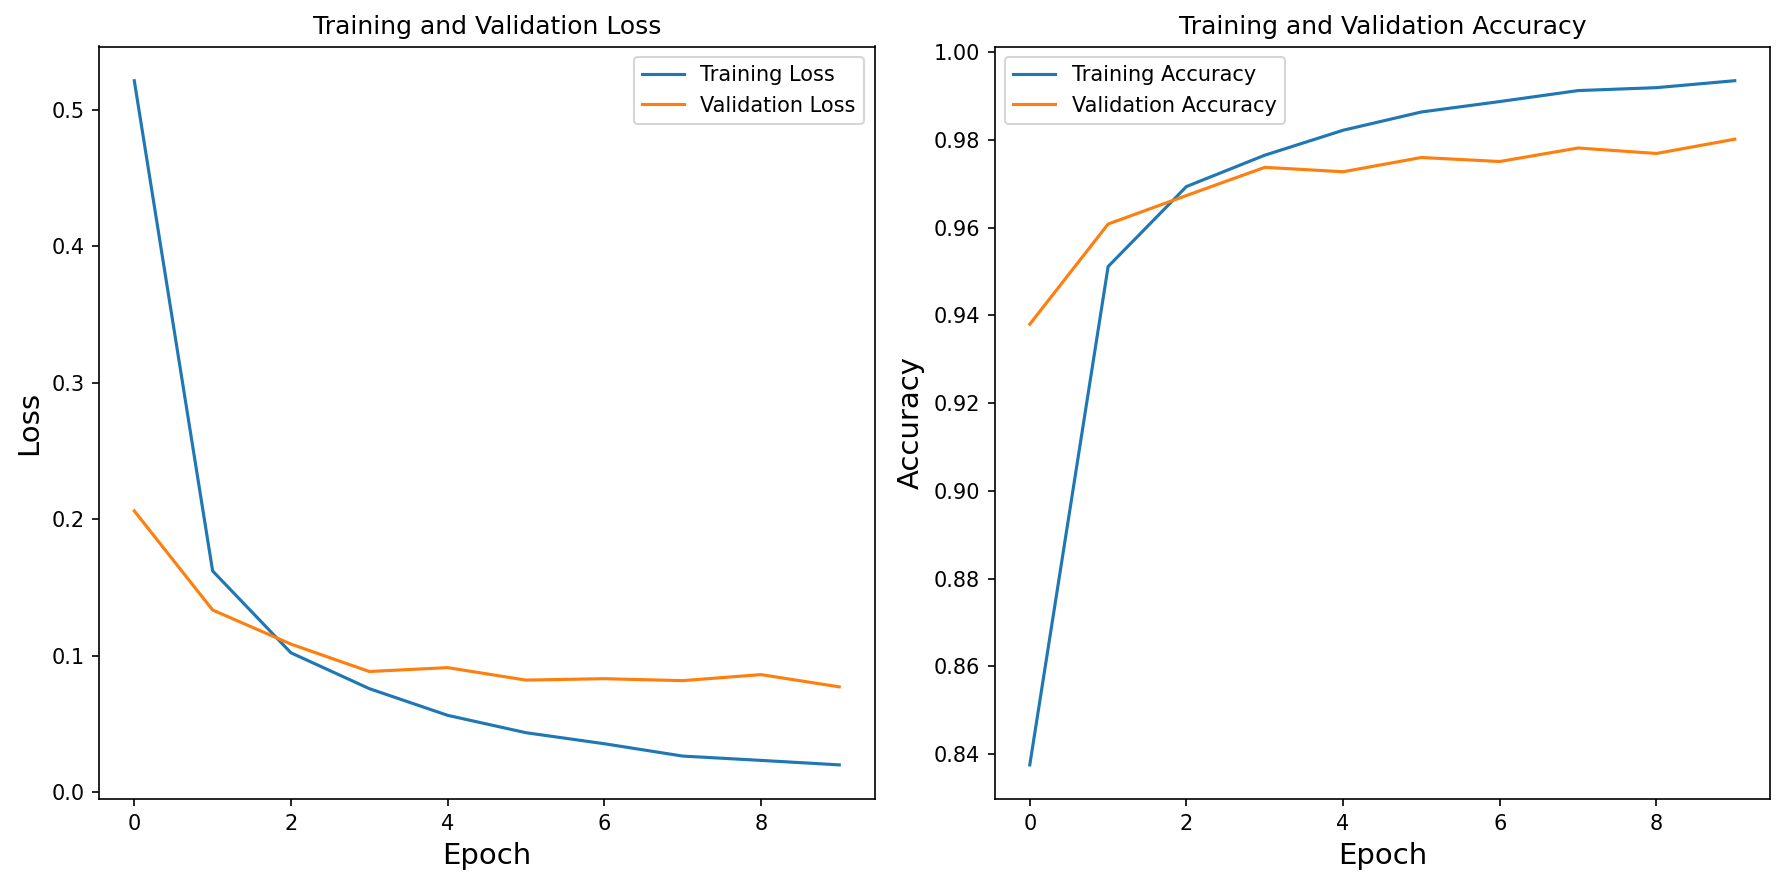

Test Accuracy 94.7%


In [26]:
model = Sequential([
    Input(shape=(28,28,1)),
    Conv2D(16, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(keras_train_X, keras_train_y, epochs=10, batch_size=128, validation_split=0.2)
plot_loss_accuracy(history)
loss, accuracy = model.evaluate(keras_test_X, keras_test_y, verbose=0)
print(f"Test Accuracy {accuracy:.1%}")

Using a combination of more and larger kernels for the 2 convolutional layers and also adding a max pooling layer between them, we are able to get a 94.7% accuracy vs. the baseline 93.0%.  We are also only having to learn 87k parameters vs. the baseline 300k.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


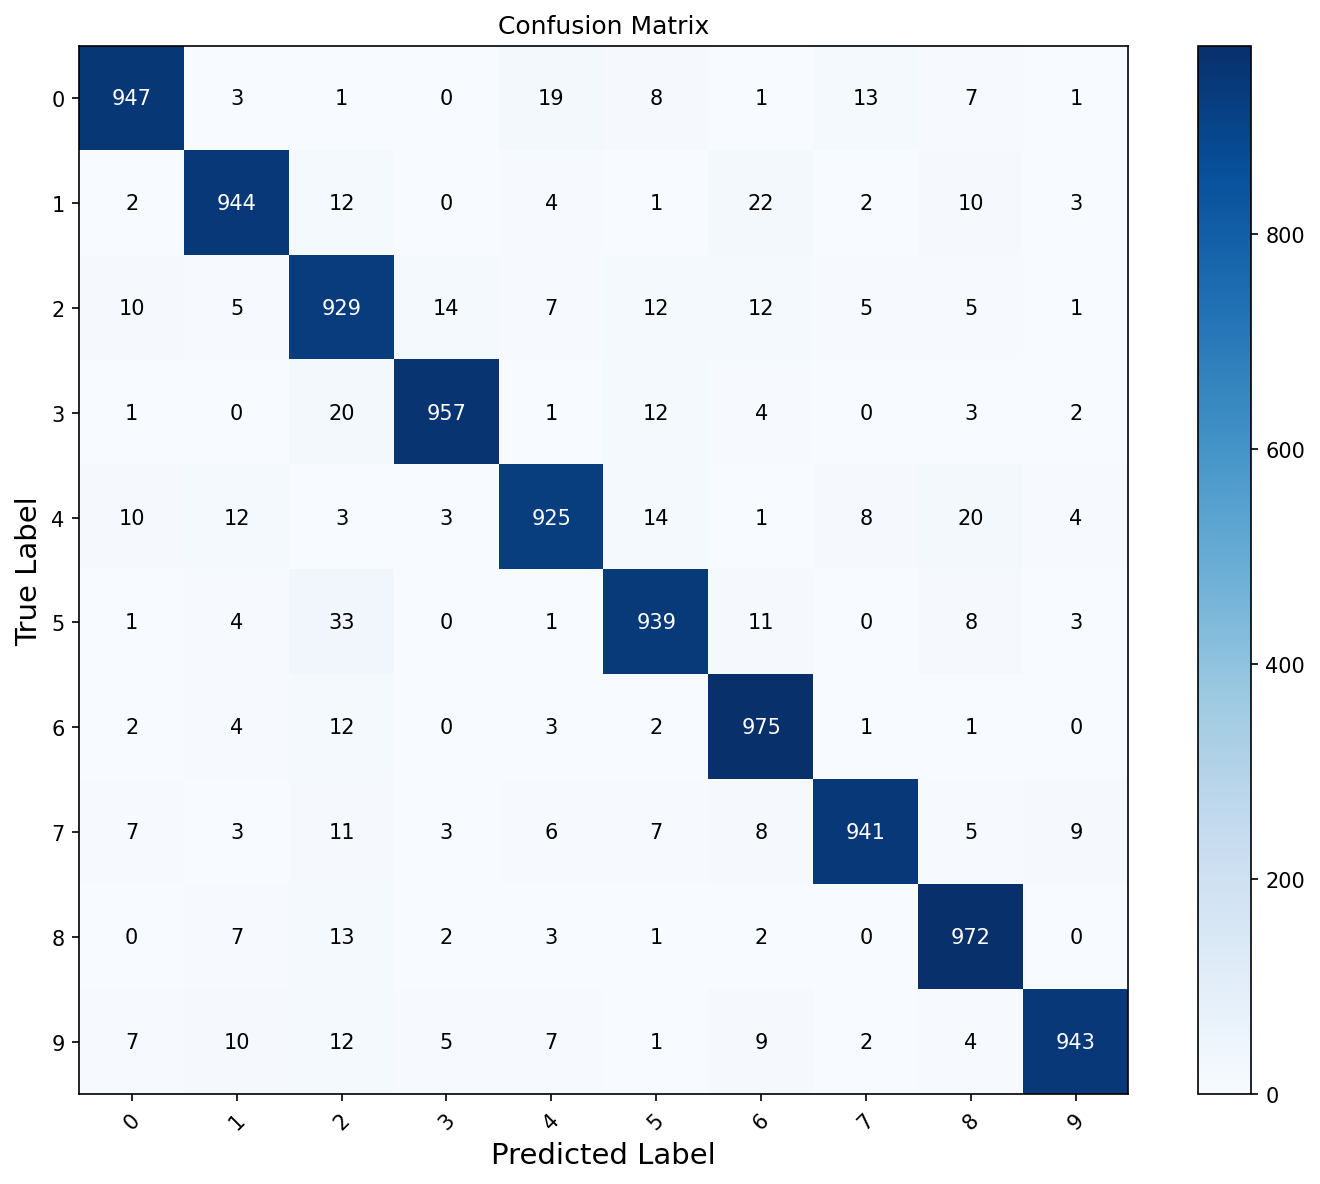

In [31]:
pred_y = plot_confusion_matrix(model)

From the confusion matrix we can see that our worst performance is for class 5 where we misclassified 33 images as class 2.

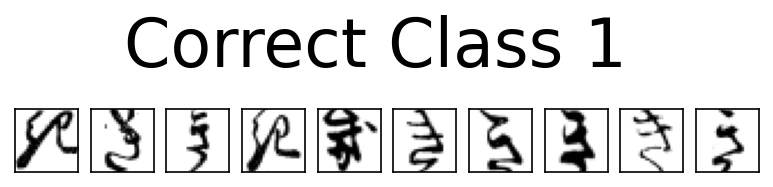

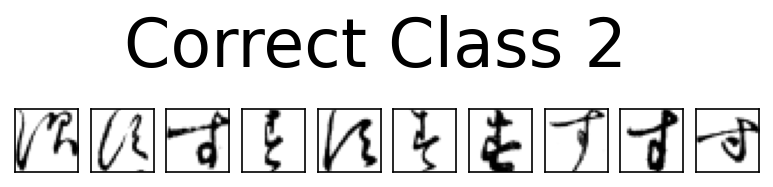

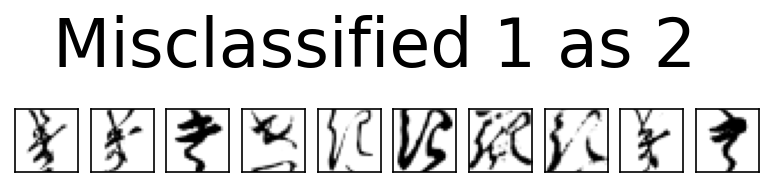

In [33]:
def show_images(title, images, count=10):
    fig, axarr = plt.subplots(1, count)
    for index in range(0, count):
        pixels = images[index]
        axarr[index].imshow(pixels, cmap='gray_r', vmin=0, vmax=255)
        axarr[index].tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    fig.suptitle(title, fontsize=32)
    plt.subplots_adjust(top=1.5)
    plt.show()


show_images("Correct Class 1", test_X[(test_y == 1) & (pred_y == 1)])
show_images("Correct Class 2", test_X[(test_y == 2) & (pred_y == 2)])
show_images("Misclassified 1 as 2", test_X[(test_y == 1) & (pred_y == 2)])